# M2177.003100 Deep Learning <br> Assignment #4 Implementing Conditional Generative Adversarial Nets - part2 MNIST data

Copyright (C) Data Science Laboratory, Seoul National University. This material is for educational uses only. Some contents are based on the material provided by other paper/book authors and may be copyrighted by them. Written by Jaeyoon Yoo, November 2017

In this notebook, you will learn how to implement conditional Genverative Adversarial Nets (cGANs) <br>
The goal here is to build GANs that draw a digit(MNIST data) given its label. <br> 

**Note**: certain details are missing or ambiguous on purpose, in order to test your knowledge on the related materials. However, if you really feel that something essential is missing and cannot proceed to the next step, then contact the teaching staff with clear description of your problem.

### Submitting your work:
<font color=red>**DO NOT clear the final outputs**</font> so that TAs can grade both your code and results.  
Once you have done **all parts**, run the *CollectSubmission.sh* script with your **Team number** as input argument. <br>
This will produce a zipped file called *[Your team number].zip*. Please submit this file on ETL. &nbsp;&nbsp; (Usage: ./*CollectSubmission.sh* &nbsp; Team_#)

### Some helpful tutorials and references for assignment #2:
- [1] TensorFlow official tutorials. [[link]](https://www.tensorflow.org/get_started/get_started)
- [2] Stanford CS231n lectures. [[link]](http://cs231n.stanford.edu/)
- [3] Goodfellow, Ian, et al. "Generative adversarial nets." Advances in neural information processing systems. 2014.
- [4] Mirza, Mehdi, and Simon Osindero. "Conditional generative adversarial nets." arXiv preprint arXiv:1411.1784 (2014).
- [5] Radford, Alec, Luke Metz, and Soumith Chintala. "Unsupervised representation learning with deep convolutional generative adversarial networks." arXiv preprint arXiv:1511.06434 (2015).

## 0. Download and load MNIST datasets
The MNIST datasets will be downloaded into the 'data' directory. If you want to change the directory the data is saved in, change mnist_data_dir with where you want. <br>

In [1]:
from download import *
import os
from utils import load_mnist
mnist_data_dir = './data'
prepare_data_dir(mnist_data_dir)
download_mnist(mnist_data_dir)
data_array , data_y = load_mnist(os.path.join(mnist_data_dir,'mnist'))
print(data_array.shape)
print(data_y.shape)

Found MNIST - skip
(70000, 28, 28, 1)
(70000, 10)


## <a name="1"></a> 1. Build a network

In this section, you will implement neural networks for (1) generative model to draw a digit (2) discriminative model to distinguish real image from generated image. You can use some function in *ops.py* or you can make it as you want. Just write the code in whatever way you find most clear.

In [2]:
from ops import conv2d
from ops import lrelu
from ops import de_conv
from ops import fully_connect
from ops import conv_cond_concat
from ops import batch_normal

import tensorflow as tf
import numpy as np

/home/pil-kso/anaconda3/envs/deep-learning-19/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/pil-kso/anaconda3/envs/deep-learning-19/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/pil-kso/anaconda3/envs/deep-learning-19/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/pil-kso

It is time for a generative model. It takes batch size, sample size(the dimension of latent variable or so called *noise*), y_dim(the dimension of label), the output size(should be 28 here) and z,y (Tensorflow Variables for latent variable and label respectively). It should return the image 28x28 output of which each element is in [0,1]. Note that you should define Tensorflow Variables within the variable scope.

You should utilize the label variable y in your model. The simplest way is concatenate the label variable and features or raw image.

In [3]:
def gern_net(batch_size, z , y , sample_size, y_dim, output_size):
    with tf.variable_scope('gen'):
        #### TODO ####
        w_init = tf.contrib.layers.xavier_initializer()
        cat = tf.concat([z, y], 1)

        fc1 = tf.layers.dense(cat, 128, kernel_initializer=w_init)
        relu = tf.nn.relu(fc1)

        fc2 = tf.layers.dense(relu, output_size*output_size, kernel_initializer=w_init)
        sigmoid = tf.nn.sigmoid(fc2)
        gen = tf.reshape(sigmoid, [batch_size, output_size, output_size, 1])
        return gen
    ####TODO ####


Now, it's time for a discriminative model. It takes image data and label variable y. It should return the value for which the model is certain that the image is real and its logit. (i.e return the value in [0,1] and its logit). Note that you should define Tensorflow Variables within the variable scope again.

You may use the label variable or not. Here, again concatenating is the simplest way to utilize it.

In [4]:
def dis_net(image_data , y, reuse=False):
    with tf.variable_scope('dis',reuse=reuse):
        #### TODO ####
        w_init = tf.contrib.layers.xavier_initializer()

        x = tf.reshape(image_data, [-1, 784])
        cat = tf.concat([x, y], 1)
        
        fc1 = tf.layers.dense(cat, 128, kernel_initializer=w_init)
        lrelu_ = lrelu(fc1)

        fc2 = tf.layers.dense(lrelu_, 1, kernel_initializer=w_init)
        dis = tf.nn.sigmoid(fc2)

        return dis, fc2
    #### TODO ####


## <a name="2"></a> 2. Build a main part and train it

In this section, you will implement the main part. You should define the loss function for each model(TODO part). Then run the code and check the model draws a digit for given label.

When you are done, run the following to check your implementations.

Following code will make 'samples_for_test' directory that resulting image will be saved in. You can change the directory as you want.

Also, you can change all other hyperparameters such as learning rate, batch size. But be sure to define **batch size bigger than 100**.

In [5]:
from utils import load_mnist
from utils import save_images
from utils import vis_square
from utils import sample_label
from utils import getNext_batch
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import os

learning_rate = 0.0001
batch_size = 128
EPOCH = 150 #2
loss_step    = 50
display_step = 50
sample_size = 100
y_dim = 10
channel = 1
output_size = 28
sample_dir = 'samples_for_test'

if os.path.exists(sample_dir) == False:
    os.makedirs(sample_dir)

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

Define the loss function in the TODO part. Modify only loss part.

Discriminator loss : log[D(x)] + log[1-D(G(z))]
Generator loss     : log[D(G(z)]

If you write the code correctly and run the code, it will display 10x10 images(each row shows one of the number). 

Also, it will save the generated images in the 'sample_dir' directory. So if you want to see it, check that directory.

**Please be sure that you ran the above codes**.

EPOCH 0 step 50: D: loss = 0.2192762 G: loss=2.9506965 
EPOCH 0 step 100: D: loss = 0.1018067 G: loss=3.7303438 
EPOCH 0 step 150: D: loss = 0.0694817 G: loss=4.1029477 
EPOCH 0 step 200: D: loss = 0.0589231 G: loss=4.5302248 
EPOCH 0 step 250: D: loss = 0.0511852 G: loss=4.6067209 
EPOCH 0 step 300: D: loss = 0.0510885 G: loss=4.9516468 
EPOCH 0 step 350: D: loss = 0.0603646 G: loss=5.0383134 
EPOCH 0 step 400: D: loss = 0.1038727 G: loss=4.4810848 
EPOCH 0 step 450: D: loss = 0.1053001 G: loss=4.3965130 
EPOCH 0 step 500: D: loss = 0.1628058 G: loss=3.7007194 


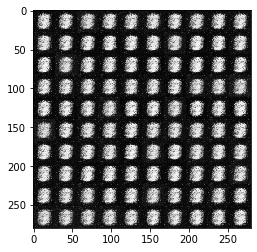

EPOCH 1 step 550: D: loss = 0.2225993 G: loss=3.2986851 
EPOCH 1 step 600: D: loss = 0.2810147 G: loss=2.8814116 
EPOCH 1 step 650: D: loss = 0.2745678 G: loss=2.7476630 
EPOCH 1 step 700: D: loss = 0.2783242 G: loss=2.6071706 
EPOCH 1 step 750: D: loss = 0.2473782 G: loss=2.7260394 
EPOCH 1 step 800: D: loss = 0.2471558 G: loss=2.6892142 
EPOCH 1 step 850: D: loss = 0.2327431 G: loss=2.6902485 
EPOCH 1 step 900: D: loss = 0.2277985 G: loss=2.6745381 
EPOCH 1 step 950: D: loss = 0.2108887 G: loss=2.6746511 
EPOCH 1 step 1000: D: loss = 0.1911407 G: loss=2.6945419 
EPOCH 1 step 1050: D: loss = 0.1733834 G: loss=2.7221680 


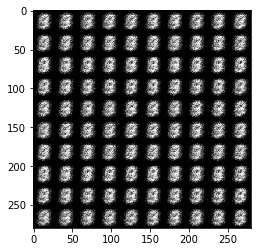

EPOCH 2 step 1100: D: loss = 0.1768571 G: loss=2.7365553 
EPOCH 2 step 1150: D: loss = 0.1795042 G: loss=2.6539452 
EPOCH 2 step 1200: D: loss = 0.1836833 G: loss=2.5809450 
EPOCH 2 step 1250: D: loss = 0.1718934 G: loss=2.6211669 
EPOCH 2 step 1300: D: loss = 0.2076780 G: loss=2.3974957 
EPOCH 2 step 1350: D: loss = 0.2406829 G: loss=2.2711546 
EPOCH 2 step 1400: D: loss = 0.2835669 G: loss=1.9696339 
EPOCH 2 step 1450: D: loss = 0.3509969 G: loss=1.8460908 
EPOCH 2 step 1500: D: loss = 0.3923897 G: loss=1.7403636 
EPOCH 2 step 1550: D: loss = 0.3954640 G: loss=1.6408830 
EPOCH 2 step 1600: D: loss = 0.4458936 G: loss=1.5006859 


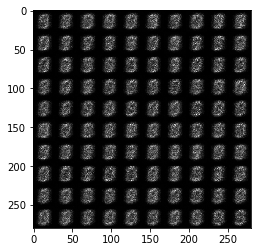

EPOCH 3 step 1650: D: loss = 0.5374773 G: loss=1.2631413 
EPOCH 3 step 1700: D: loss = 0.4413587 G: loss=1.3757688 
EPOCH 3 step 1750: D: loss = 0.4635462 G: loss=1.3699102 
EPOCH 3 step 1800: D: loss = 0.4689688 G: loss=1.3265390 
EPOCH 3 step 1850: D: loss = 0.4202333 G: loss=1.3952465 
EPOCH 3 step 1900: D: loss = 0.4244213 G: loss=1.4117811 
EPOCH 3 step 1950: D: loss = 0.3650059 G: loss=1.5194774 
EPOCH 3 step 2000: D: loss = 0.3172498 G: loss=1.6273782 
EPOCH 3 step 2050: D: loss = 0.3214639 G: loss=1.6199822 
EPOCH 3 step 2100: D: loss = 0.2619138 G: loss=1.7127385 
EPOCH 3 step 2150: D: loss = 0.2745508 G: loss=1.8013668 


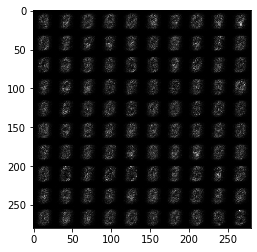

EPOCH 4 step 2200: D: loss = 0.2655546 G: loss=1.8719537 
EPOCH 4 step 2250: D: loss = 0.2002728 G: loss=2.0114577 
EPOCH 4 step 2300: D: loss = 0.1956036 G: loss=2.0985394 
EPOCH 4 step 2350: D: loss = 0.1843470 G: loss=2.1841989 
EPOCH 4 step 2400: D: loss = 0.1680279 G: loss=2.2129798 
EPOCH 4 step 2450: D: loss = 0.1482168 G: loss=2.4298863 
EPOCH 4 step 2500: D: loss = 0.1690599 G: loss=2.4477208 
EPOCH 4 step 2550: D: loss = 0.1778249 G: loss=2.3802345 
EPOCH 4 step 2600: D: loss = 0.1687721 G: loss=2.4865384 
EPOCH 4 step 2650: D: loss = 0.1574273 G: loss=2.6055441 
EPOCH 4 step 2700: D: loss = 0.1572426 G: loss=2.5936368 


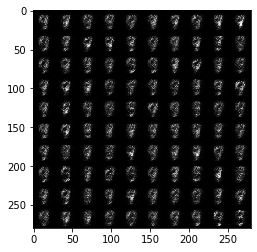

EPOCH 5 step 2750: D: loss = 0.1811763 G: loss=2.5191808 
EPOCH 5 step 2800: D: loss = 0.1582679 G: loss=2.7094555 
EPOCH 5 step 2850: D: loss = 0.1662925 G: loss=2.7072182 
EPOCH 5 step 2900: D: loss = 0.2235651 G: loss=2.5907753 
EPOCH 5 step 2950: D: loss = 0.2344786 G: loss=2.5981715 
EPOCH 5 step 3000: D: loss = 0.1811058 G: loss=2.5379927 
EPOCH 5 step 3050: D: loss = 0.1999070 G: loss=2.7539821 
EPOCH 5 step 3100: D: loss = 0.1750114 G: loss=2.7643669 
EPOCH 5 step 3150: D: loss = 0.2039959 G: loss=2.8155627 
EPOCH 5 step 3200: D: loss = 0.1840792 G: loss=2.7278237 
EPOCH 5 step 3250: D: loss = 0.2057178 G: loss=2.7653589 


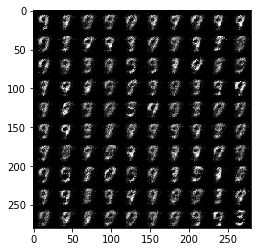

EPOCH 6 step 3300: D: loss = 0.1797877 G: loss=3.0507364 
EPOCH 6 step 3350: D: loss = 0.1981810 G: loss=3.0726309 
EPOCH 6 step 3400: D: loss = 0.2397113 G: loss=2.7386498 
EPOCH 6 step 3450: D: loss = 0.2700015 G: loss=2.6847601 
EPOCH 6 step 3500: D: loss = 0.2577508 G: loss=2.8556995 
EPOCH 6 step 3550: D: loss = 0.2885531 G: loss=2.7283311 
EPOCH 6 step 3600: D: loss = 0.3193129 G: loss=2.7239423 
EPOCH 6 step 3650: D: loss = 0.2979892 G: loss=2.6602745 
EPOCH 6 step 3700: D: loss = 0.3602557 G: loss=2.3442855 
EPOCH 6 step 3750: D: loss = 0.3808817 G: loss=2.4028776 
EPOCH 6 step 3800: D: loss = 0.2676842 G: loss=2.6790447 


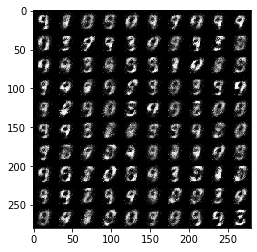

EPOCH 7 step 3850: D: loss = 0.3271592 G: loss=2.8159168 
EPOCH 7 step 3900: D: loss = 0.3332762 G: loss=2.5265703 
EPOCH 7 step 3950: D: loss = 0.3046415 G: loss=2.6733885 
EPOCH 7 step 4000: D: loss = 0.3048169 G: loss=2.5422735 
EPOCH 7 step 4050: D: loss = 0.3683607 G: loss=2.2344820 
EPOCH 7 step 4100: D: loss = 0.3867851 G: loss=2.1985056 
EPOCH 7 step 4150: D: loss = 0.3256138 G: loss=2.4834533 
EPOCH 7 step 4200: D: loss = 0.2416878 G: loss=2.5825343 
EPOCH 7 step 4250: D: loss = 0.3303419 G: loss=2.4185567 
EPOCH 7 step 4300: D: loss = 0.3408416 G: loss=2.4934752 
EPOCH 7 step 4350: D: loss = 0.4333851 G: loss=2.3402348 


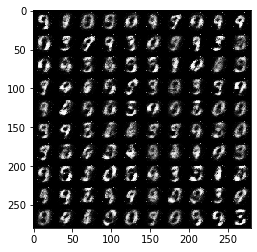

EPOCH 8 step 4400: D: loss = 0.4259987 G: loss=2.2400095 
EPOCH 8 step 4450: D: loss = 0.3728008 G: loss=2.3005004 
EPOCH 8 step 4500: D: loss = 0.2713720 G: loss=2.6589603 
EPOCH 8 step 4550: D: loss = 0.3546359 G: loss=2.3360908 
EPOCH 8 step 4600: D: loss = 0.3979602 G: loss=2.4134071 
EPOCH 8 step 4650: D: loss = 0.3132591 G: loss=2.5606697 
EPOCH 8 step 4700: D: loss = 0.3380874 G: loss=2.4360018 
EPOCH 8 step 4750: D: loss = 0.3640553 G: loss=2.3162313 
EPOCH 8 step 4800: D: loss = 0.4114494 G: loss=2.3160114 
EPOCH 8 step 4850: D: loss = 0.3652111 G: loss=2.4529271 
EPOCH 8 step 4900: D: loss = 0.3106217 G: loss=2.5831065 


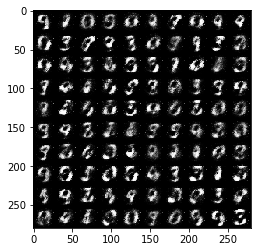

EPOCH 9 step 4950: D: loss = 0.3653976 G: loss=2.3324993 
EPOCH 9 step 5000: D: loss = 0.3765565 G: loss=2.1843710 
EPOCH 9 step 5050: D: loss = 0.3075680 G: loss=2.4248638 
EPOCH 9 step 5100: D: loss = 0.4238264 G: loss=1.9769877 
EPOCH 9 step 5150: D: loss = 0.3695715 G: loss=2.3343840 
EPOCH 9 step 5200: D: loss = 0.3044184 G: loss=2.4394341 
EPOCH 9 step 5250: D: loss = 0.3322358 G: loss=2.3758900 
EPOCH 9 step 5300: D: loss = 0.3059357 G: loss=2.4431143 
EPOCH 9 step 5350: D: loss = 0.2917709 G: loss=2.8042855 
EPOCH 9 step 5400: D: loss = 0.3273578 G: loss=2.4102888 
EPOCH 9 step 5450: D: loss = 0.2861522 G: loss=2.5230410 


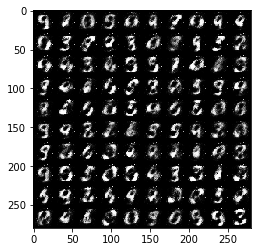

EPOCH 10 step 5500: D: loss = 0.3598639 G: loss=2.4023485 
EPOCH 10 step 5550: D: loss = 0.2394533 G: loss=2.6067667 
EPOCH 10 step 5600: D: loss = 0.2080431 G: loss=2.6858537 
EPOCH 10 step 5650: D: loss = 0.2362093 G: loss=2.6208932 
EPOCH 10 step 5700: D: loss = 0.2937702 G: loss=2.7836177 
EPOCH 10 step 5750: D: loss = 0.2932036 G: loss=2.6169581 
EPOCH 10 step 5800: D: loss = 0.3624501 G: loss=2.4487617 
EPOCH 10 step 5850: D: loss = 0.3135555 G: loss=2.3643336 
EPOCH 10 step 5900: D: loss = 0.3253696 G: loss=2.5261946 
EPOCH 10 step 5950: D: loss = 0.3122264 G: loss=2.3479476 
EPOCH 10 step 6000: D: loss = 0.2687304 G: loss=2.6770062 


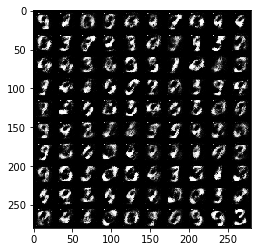

EPOCH 11 step 6050: D: loss = 0.3321840 G: loss=2.4171319 
EPOCH 11 step 6100: D: loss = 0.3249021 G: loss=2.4200404 
EPOCH 11 step 6150: D: loss = 0.3350942 G: loss=2.3205342 
EPOCH 11 step 6200: D: loss = 0.3798281 G: loss=2.3431122 
EPOCH 11 step 6250: D: loss = 0.3468078 G: loss=2.3332438 
EPOCH 11 step 6300: D: loss = 0.3568290 G: loss=2.5319390 
EPOCH 11 step 6350: D: loss = 0.3105752 G: loss=2.4482448 
EPOCH 11 step 6400: D: loss = 0.2905386 G: loss=2.4067254 
EPOCH 11 step 6450: D: loss = 0.3355111 G: loss=2.2966206 
EPOCH 11 step 6500: D: loss = 0.2833676 G: loss=2.5301867 
EPOCH 11 step 6550: D: loss = 0.2748521 G: loss=2.4658208 


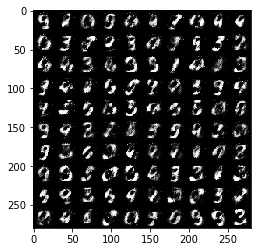

EPOCH 12 step 6600: D: loss = 0.2602434 G: loss=2.6910830 
EPOCH 12 step 6650: D: loss = 0.3195860 G: loss=2.5309033 
EPOCH 12 step 6700: D: loss = 0.3711138 G: loss=2.2547669 
EPOCH 12 step 6750: D: loss = 0.3785221 G: loss=2.2381806 
EPOCH 12 step 6800: D: loss = 0.4192339 G: loss=2.2364626 
EPOCH 12 step 6850: D: loss = 0.2928036 G: loss=2.6221998 
EPOCH 12 step 6900: D: loss = 0.2572823 G: loss=2.6872201 
EPOCH 12 step 6950: D: loss = 0.1864467 G: loss=2.8839560 
EPOCH 12 step 7000: D: loss = 0.2472080 G: loss=2.7932863 
EPOCH 12 step 7050: D: loss = 0.4489630 G: loss=2.2776563 


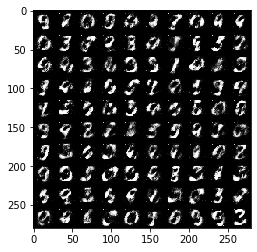

EPOCH 13 step 7100: D: loss = 0.5069813 G: loss=2.1280642 
EPOCH 13 step 7150: D: loss = 0.4070823 G: loss=2.3343995 
EPOCH 13 step 7200: D: loss = 0.2687521 G: loss=2.7219987 
EPOCH 13 step 7250: D: loss = 0.3214714 G: loss=2.6096554 
EPOCH 13 step 7300: D: loss = 0.2825084 G: loss=2.8122568 
EPOCH 13 step 7350: D: loss = 0.3981830 G: loss=2.5373027 
EPOCH 13 step 7400: D: loss = 0.3187013 G: loss=2.6865008 
EPOCH 13 step 7450: D: loss = 0.3783031 G: loss=2.4871659 
EPOCH 13 step 7500: D: loss = 0.4048579 G: loss=2.3900037 
EPOCH 13 step 7550: D: loss = 0.4555975 G: loss=2.3403232 
EPOCH 13 step 7600: D: loss = 0.3782408 G: loss=2.3313663 


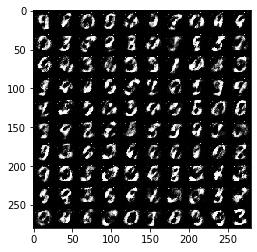

EPOCH 14 step 7650: D: loss = 0.4114141 G: loss=2.4424868 
EPOCH 14 step 7700: D: loss = 0.3645189 G: loss=2.4450030 
EPOCH 14 step 7750: D: loss = 0.5121220 G: loss=2.1948352 
EPOCH 14 step 7800: D: loss = 0.3714580 G: loss=2.3106918 
EPOCH 14 step 7850: D: loss = 0.3525775 G: loss=2.3762584 
EPOCH 14 step 7900: D: loss = 0.3155712 G: loss=2.4862938 
EPOCH 14 step 7950: D: loss = 0.3563955 G: loss=2.5345480 
EPOCH 14 step 8000: D: loss = 0.4276958 G: loss=2.4671073 
EPOCH 14 step 8050: D: loss = 0.5521667 G: loss=1.8260932 
EPOCH 14 step 8100: D: loss = 0.4844032 G: loss=2.1643224 
EPOCH 14 step 8150: D: loss = 0.5104589 G: loss=2.0888772 


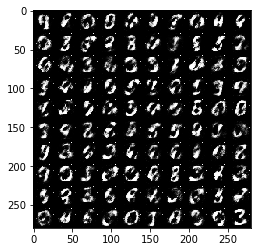

EPOCH 15 step 8200: D: loss = 0.3571625 G: loss=2.3887300 
EPOCH 15 step 8250: D: loss = 0.2857255 G: loss=2.6355851 
EPOCH 15 step 8300: D: loss = 0.2625580 G: loss=2.7358041 
EPOCH 15 step 8350: D: loss = 0.4449431 G: loss=2.0079026 
EPOCH 15 step 8400: D: loss = 0.4691057 G: loss=2.2146606 
EPOCH 15 step 8450: D: loss = 0.4934752 G: loss=2.1681557 
EPOCH 15 step 8500: D: loss = 0.3700672 G: loss=2.2506936 
EPOCH 15 step 8550: D: loss = 0.3402467 G: loss=2.3658118 
EPOCH 15 step 8600: D: loss = 0.5048909 G: loss=2.3682427 
EPOCH 15 step 8650: D: loss = 0.4326693 G: loss=2.2034845 
EPOCH 15 step 8700: D: loss = 0.2428645 G: loss=2.7608421 


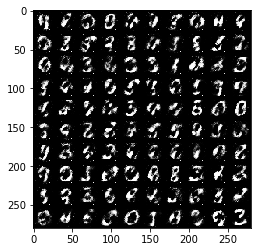

EPOCH 16 step 8750: D: loss = 0.3793799 G: loss=2.3374946 
EPOCH 16 step 8800: D: loss = 0.4164178 G: loss=2.2187281 
EPOCH 16 step 8850: D: loss = 0.4215075 G: loss=2.2208879 
EPOCH 16 step 8900: D: loss = 0.3108882 G: loss=2.5289328 
EPOCH 16 step 8950: D: loss = 0.2354330 G: loss=2.6739814 
EPOCH 16 step 9000: D: loss = 0.3495998 G: loss=2.5422020 
EPOCH 16 step 9050: D: loss = 0.4638464 G: loss=2.0237403 
EPOCH 16 step 9100: D: loss = 0.4322413 G: loss=2.1453843 
EPOCH 16 step 9150: D: loss = 0.3896071 G: loss=2.3885670 
EPOCH 16 step 9200: D: loss = 0.3876848 G: loss=2.5667756 
EPOCH 16 step 9250: D: loss = 0.3541258 G: loss=2.4763801 


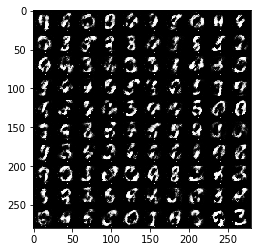

EPOCH 17 step 9300: D: loss = 0.4027464 G: loss=2.3198025 
EPOCH 17 step 9350: D: loss = 0.4084610 G: loss=2.4170547 
EPOCH 17 step 9400: D: loss = 0.4051986 G: loss=2.3019962 
EPOCH 17 step 9450: D: loss = 0.4751223 G: loss=2.1366506 
EPOCH 17 step 9500: D: loss = 0.4057749 G: loss=2.4255023 
EPOCH 17 step 9550: D: loss = 0.3890788 G: loss=2.3241234 
EPOCH 17 step 9600: D: loss = 0.4280083 G: loss=2.2438102 
EPOCH 17 step 9650: D: loss = 0.4258431 G: loss=2.2530954 
EPOCH 17 step 9700: D: loss = 0.3508816 G: loss=2.2491629 
EPOCH 17 step 9750: D: loss = 0.3855354 G: loss=2.4756842 
EPOCH 17 step 9800: D: loss = 0.4697272 G: loss=2.3056760 


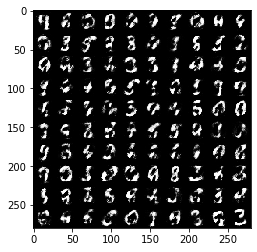

EPOCH 18 step 9850: D: loss = 0.4108747 G: loss=2.3312030 
EPOCH 18 step 9900: D: loss = 0.3574180 G: loss=2.4926975 
EPOCH 18 step 9950: D: loss = 0.3106920 G: loss=2.6054270 
EPOCH 18 step 10000: D: loss = 0.3452039 G: loss=2.4167809 
EPOCH 18 step 10050: D: loss = 0.3952288 G: loss=2.2405000 
EPOCH 18 step 10100: D: loss = 0.3929735 G: loss=2.4380345 
EPOCH 18 step 10150: D: loss = 0.4817703 G: loss=2.3371987 
EPOCH 18 step 10200: D: loss = 0.4052930 G: loss=2.2529073 
EPOCH 18 step 10250: D: loss = 0.4456055 G: loss=2.2306612 
EPOCH 18 step 10300: D: loss = 0.4491120 G: loss=2.1991413 
EPOCH 18 step 10350: D: loss = 0.3715899 G: loss=2.3314402 


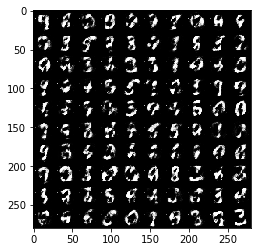

EPOCH 19 step 10400: D: loss = 0.4006745 G: loss=2.4461815 
EPOCH 19 step 10450: D: loss = 0.4107854 G: loss=2.4558215 
EPOCH 19 step 10500: D: loss = 0.3892770 G: loss=2.2688260 
EPOCH 19 step 10550: D: loss = 0.4812649 G: loss=1.9997563 
EPOCH 19 step 10600: D: loss = 0.3838890 G: loss=2.3330126 
EPOCH 19 step 10650: D: loss = 0.5080072 G: loss=2.1921017 
EPOCH 19 step 10700: D: loss = 0.2846874 G: loss=2.7546868 
EPOCH 19 step 10750: D: loss = 0.3838813 G: loss=2.4515498 
EPOCH 19 step 10800: D: loss = 0.3282019 G: loss=2.3925805 
EPOCH 19 step 10850: D: loss = 0.2924963 G: loss=2.5691531 
EPOCH 19 step 10900: D: loss = 0.3935409 G: loss=2.4569249 


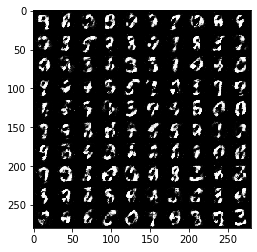

EPOCH 20 step 10950: D: loss = 0.4101220 G: loss=2.2050693 
EPOCH 20 step 11000: D: loss = 0.3495136 G: loss=2.3195856 
EPOCH 20 step 11050: D: loss = 0.3502741 G: loss=2.4108999 
EPOCH 20 step 11100: D: loss = 0.3085462 G: loss=2.3586049 
EPOCH 20 step 11150: D: loss = 0.3876974 G: loss=2.3547068 
EPOCH 20 step 11200: D: loss = 0.5044008 G: loss=2.2485282 
EPOCH 20 step 11250: D: loss = 0.2829527 G: loss=2.5097389 
EPOCH 20 step 11300: D: loss = 0.3212917 G: loss=2.3813114 
EPOCH 20 step 11350: D: loss = 0.4374318 G: loss=2.2604747 
EPOCH 20 step 11400: D: loss = 0.4329489 G: loss=2.0858164 
EPOCH 20 step 11450: D: loss = 0.3065228 G: loss=2.5463185 


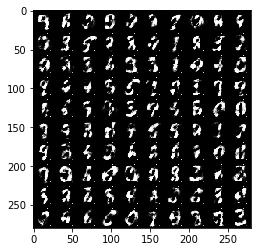

EPOCH 21 step 11500: D: loss = 0.3573593 G: loss=2.5983901 
EPOCH 21 step 11550: D: loss = 0.3419442 G: loss=2.6729476 
EPOCH 21 step 11600: D: loss = 0.4460192 G: loss=2.1604462 
EPOCH 21 step 11650: D: loss = 0.4244238 G: loss=2.2874453 
EPOCH 21 step 11700: D: loss = 0.2962397 G: loss=2.7073057 
EPOCH 21 step 11750: D: loss = 0.4098765 G: loss=2.3834214 
EPOCH 21 step 11800: D: loss = 0.3720622 G: loss=2.3392510 
EPOCH 21 step 11850: D: loss = 0.6940587 G: loss=1.8227823 
EPOCH 21 step 11900: D: loss = 0.7964578 G: loss=1.6336067 
EPOCH 21 step 11950: D: loss = 0.5885991 G: loss=1.9419129 
EPOCH 21 step 12000: D: loss = 0.5819927 G: loss=1.8851207 


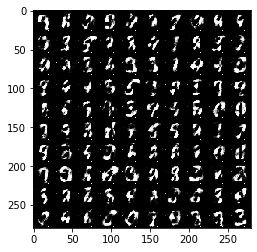

EPOCH 22 step 12050: D: loss = 0.3766681 G: loss=2.2836165 
EPOCH 22 step 12100: D: loss = 0.4416735 G: loss=2.4014063 
EPOCH 22 step 12150: D: loss = 0.3303822 G: loss=2.3995848 
EPOCH 22 step 12200: D: loss = 0.3764774 G: loss=2.5018117 
EPOCH 22 step 12250: D: loss = 0.5517061 G: loss=2.2470107 
EPOCH 22 step 12300: D: loss = 0.2779374 G: loss=2.9621894 
EPOCH 22 step 12350: D: loss = 0.2878043 G: loss=2.7785449 
EPOCH 22 step 12400: D: loss = 0.1642142 G: loss=3.2804475 
EPOCH 22 step 12450: D: loss = 0.2444011 G: loss=2.8939497 
EPOCH 22 step 12500: D: loss = 0.3020442 G: loss=2.6302490 
EPOCH 22 step 12550: D: loss = 0.2779017 G: loss=3.0086157 


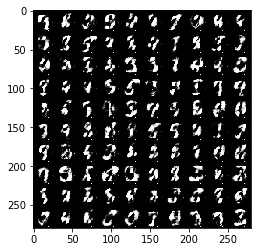

EPOCH 23 step 12600: D: loss = 0.2016907 G: loss=3.0659504 
EPOCH 23 step 12650: D: loss = 0.2108839 G: loss=3.5444038 
EPOCH 23 step 12700: D: loss = 0.2351533 G: loss=3.5085020 
EPOCH 23 step 12750: D: loss = 0.2874736 G: loss=3.0545254 
EPOCH 23 step 12800: D: loss = 0.3803235 G: loss=2.8121316 
EPOCH 23 step 12850: D: loss = 0.6183222 G: loss=2.2126532 
EPOCH 23 step 12900: D: loss = 1.1147237 G: loss=1.7279525 
EPOCH 23 step 12950: D: loss = 1.7643015 G: loss=1.0279310 
EPOCH 23 step 13000: D: loss = 1.2058198 G: loss=1.3453245 
EPOCH 23 step 13050: D: loss = 0.8251977 G: loss=1.6269461 
EPOCH 23 step 13100: D: loss = 1.9549432 G: loss=0.7870977 


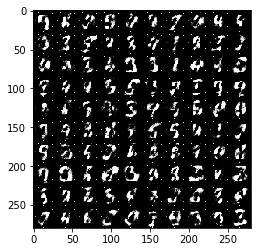

EPOCH 24 step 13150: D: loss = 1.2785510 G: loss=1.2516167 
EPOCH 24 step 13200: D: loss = 1.0465070 G: loss=1.4617584 
EPOCH 24 step 13250: D: loss = 0.7932825 G: loss=1.6847093 
EPOCH 24 step 13300: D: loss = 0.5369932 G: loss=2.0251732 
EPOCH 24 step 13350: D: loss = 0.4376462 G: loss=2.2161980 
EPOCH 24 step 13400: D: loss = 0.4482266 G: loss=2.4048815 
EPOCH 24 step 13450: D: loss = 0.3865430 G: loss=2.4981706 
EPOCH 24 step 13500: D: loss = 0.4181017 G: loss=2.4970851 
EPOCH 24 step 13550: D: loss = 0.3575332 G: loss=2.5849640 
EPOCH 24 step 13600: D: loss = 0.4094023 G: loss=2.5803175 
EPOCH 24 step 13650: D: loss = 0.2472875 G: loss=3.1084826 


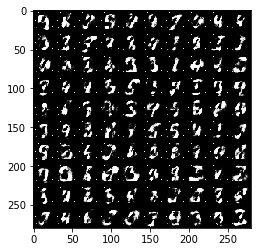

EPOCH 25 step 13700: D: loss = 0.2218891 G: loss=2.9584293 
EPOCH 25 step 13750: D: loss = 0.2128132 G: loss=3.2873597 
EPOCH 25 step 13800: D: loss = 0.1893842 G: loss=3.4172866 
EPOCH 25 step 13850: D: loss = 0.2158434 G: loss=3.1691017 
EPOCH 25 step 13900: D: loss = 0.1602609 G: loss=3.6067336 
EPOCH 25 step 13950: D: loss = 0.2217860 G: loss=3.3738089 
EPOCH 25 step 14000: D: loss = 0.2451081 G: loss=3.3721466 
EPOCH 25 step 14050: D: loss = 0.2462139 G: loss=3.5265644 
EPOCH 25 step 14100: D: loss = 0.2647776 G: loss=3.2651200 
EPOCH 25 step 14150: D: loss = 0.2287886 G: loss=3.2250693 


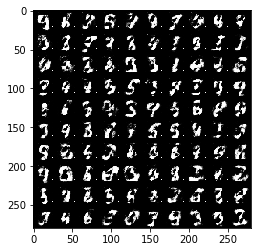

EPOCH 26 step 14200: D: loss = 0.2899114 G: loss=3.1083093 
EPOCH 26 step 14250: D: loss = 0.2534134 G: loss=3.0519342 
EPOCH 26 step 14300: D: loss = 0.3074043 G: loss=2.8135750 
EPOCH 26 step 14350: D: loss = 0.3277245 G: loss=2.9398584 
EPOCH 26 step 14400: D: loss = 0.2061334 G: loss=3.2194717 
EPOCH 26 step 14450: D: loss = 0.3294024 G: loss=2.8223326 
EPOCH 26 step 14500: D: loss = 0.2916461 G: loss=2.9885981 
EPOCH 26 step 14550: D: loss = 0.4569293 G: loss=2.6096916 
EPOCH 26 step 14600: D: loss = 0.4475594 G: loss=2.5185881 
EPOCH 26 step 14650: D: loss = 0.6418326 G: loss=2.3022738 
EPOCH 26 step 14700: D: loss = 0.4592978 G: loss=2.2713203 


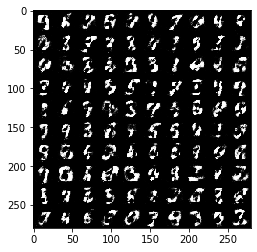

EPOCH 27 step 14750: D: loss = 0.4808487 G: loss=2.3532054 
EPOCH 27 step 14800: D: loss = 0.4301024 G: loss=2.4114249 
EPOCH 27 step 14850: D: loss = 0.4406314 G: loss=2.1720366 
EPOCH 27 step 14900: D: loss = 0.4224447 G: loss=2.2887621 
EPOCH 27 step 14950: D: loss = 0.4121608 G: loss=2.4346604 
EPOCH 27 step 15000: D: loss = 0.4235814 G: loss=2.2103341 
EPOCH 27 step 15050: D: loss = 0.4116625 G: loss=2.3339429 
EPOCH 27 step 15100: D: loss = 0.4336774 G: loss=2.2269161 
EPOCH 27 step 15150: D: loss = 0.4473379 G: loss=2.1528485 
EPOCH 27 step 15200: D: loss = 0.3761804 G: loss=2.4061751 
EPOCH 27 step 15250: D: loss = 0.4009686 G: loss=2.3391337 


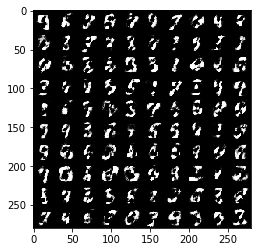

EPOCH 28 step 15300: D: loss = 0.5910380 G: loss=2.1072447 
EPOCH 28 step 15350: D: loss = 0.4823826 G: loss=2.1767850 
EPOCH 28 step 15400: D: loss = 0.3990485 G: loss=2.4392149 
EPOCH 28 step 15450: D: loss = 0.4432367 G: loss=2.3358345 
EPOCH 28 step 15500: D: loss = 0.2941043 G: loss=2.6876743 
EPOCH 28 step 15550: D: loss = 0.2622371 G: loss=2.9736941 
EPOCH 28 step 15600: D: loss = 0.2209509 G: loss=2.9303136 
EPOCH 28 step 15650: D: loss = 0.3537782 G: loss=2.5112202 
EPOCH 28 step 15700: D: loss = 0.3505801 G: loss=2.4742959 
EPOCH 28 step 15750: D: loss = 0.3699561 G: loss=2.5987306 
EPOCH 28 step 15800: D: loss = 0.3483244 G: loss=2.5273566 


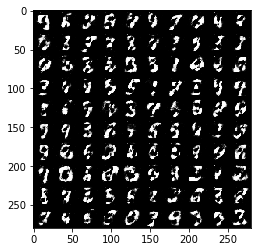

EPOCH 29 step 15850: D: loss = 0.6548872 G: loss=1.7622796 
EPOCH 29 step 15900: D: loss = 0.5749341 G: loss=1.9778633 
EPOCH 29 step 15950: D: loss = 0.4625947 G: loss=2.3207657 
EPOCH 29 step 16000: D: loss = 0.4356843 G: loss=2.5186744 
EPOCH 29 step 16050: D: loss = 0.3332933 G: loss=2.6631486 
EPOCH 29 step 16100: D: loss = 0.3248557 G: loss=2.6737406 
EPOCH 29 step 16150: D: loss = 0.3487007 G: loss=2.9254601 
EPOCH 29 step 16200: D: loss = 0.2885690 G: loss=2.7911568 
EPOCH 29 step 16250: D: loss = 0.2599514 G: loss=2.8441069 
EPOCH 29 step 16300: D: loss = 0.3661482 G: loss=2.6835496 
EPOCH 29 step 16350: D: loss = 0.3779691 G: loss=2.3580506 


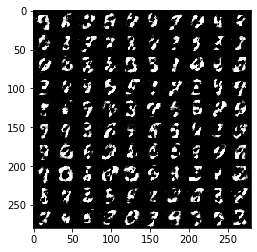

EPOCH 30 step 16400: D: loss = 0.5248488 G: loss=2.1996214 
EPOCH 30 step 16450: D: loss = 0.4238473 G: loss=2.4669843 
EPOCH 30 step 16500: D: loss = 0.5602437 G: loss=2.1230416 
EPOCH 30 step 16550: D: loss = 0.3659348 G: loss=2.5910246 
EPOCH 30 step 16600: D: loss = 0.4039871 G: loss=2.3685372 
EPOCH 30 step 16650: D: loss = 0.4333307 G: loss=2.5827365 
EPOCH 30 step 16700: D: loss = 0.4118449 G: loss=2.5192661 
EPOCH 30 step 16750: D: loss = 0.3352080 G: loss=2.5469010 
EPOCH 30 step 16800: D: loss = 0.4033689 G: loss=2.5553045 
EPOCH 30 step 16850: D: loss = 0.4292383 G: loss=2.4596934 
EPOCH 30 step 16900: D: loss = 0.3818471 G: loss=2.5798564 


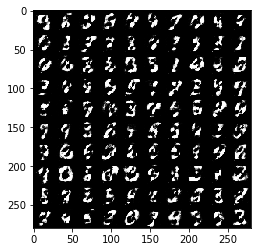

EPOCH 31 step 16950: D: loss = 0.4641164 G: loss=2.4385591 
EPOCH 31 step 17000: D: loss = 0.4429680 G: loss=2.3593979 
EPOCH 31 step 17050: D: loss = 0.4475280 G: loss=2.3444996 
EPOCH 31 step 17100: D: loss = 0.4189841 G: loss=2.6076257 
EPOCH 31 step 17150: D: loss = 0.3333527 G: loss=2.5228219 
EPOCH 31 step 17200: D: loss = 0.8246326 G: loss=1.7095976 
EPOCH 31 step 17250: D: loss = 0.7421089 G: loss=1.9674672 
EPOCH 31 step 17300: D: loss = 0.5140691 G: loss=2.3583333 
EPOCH 31 step 17350: D: loss = 0.4067983 G: loss=2.3739586 
EPOCH 31 step 17400: D: loss = 0.4511147 G: loss=2.4582872 
EPOCH 31 step 17450: D: loss = 0.2862542 G: loss=2.9701009 


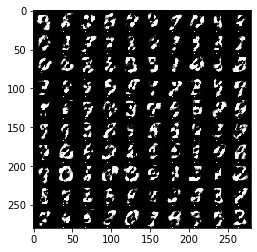

EPOCH 32 step 17500: D: loss = 0.3551071 G: loss=2.7568896 
EPOCH 32 step 17550: D: loss = 0.3123924 G: loss=2.6873097 
EPOCH 32 step 17600: D: loss = 0.3565003 G: loss=2.8772607 
EPOCH 32 step 17650: D: loss = 0.2581729 G: loss=2.9037597 
EPOCH 32 step 17700: D: loss = 0.4595401 G: loss=2.4990029 
EPOCH 32 step 17750: D: loss = 0.4458223 G: loss=2.3857613 
EPOCH 32 step 17800: D: loss = 0.4393117 G: loss=2.6428852 
EPOCH 32 step 17850: D: loss = 0.4470967 G: loss=2.3804584 
EPOCH 32 step 17900: D: loss = 0.3631768 G: loss=2.6991944 
EPOCH 32 step 17950: D: loss = 0.3633454 G: loss=2.5156035 
EPOCH 32 step 18000: D: loss = 0.4711448 G: loss=2.5243640 


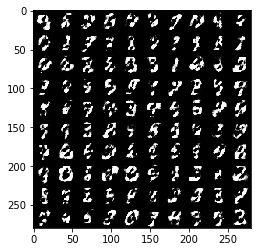

EPOCH 33 step 18050: D: loss = 0.4602645 G: loss=2.4438138 
EPOCH 33 step 18100: D: loss = 0.4399918 G: loss=2.5228717 
EPOCH 33 step 18150: D: loss = 3.9563870 G: loss=0.4111990 
EPOCH 33 step 18200: D: loss = 4.7872357 G: loss=0.2931230 
EPOCH 33 step 18250: D: loss = 3.4108543 G: loss=0.4684194 
EPOCH 33 step 18300: D: loss = 2.4080915 G: loss=0.6977727 
EPOCH 33 step 18350: D: loss = 1.6796360 G: loss=1.0401368 
EPOCH 33 step 18400: D: loss = 1.2330430 G: loss=1.1375921 
EPOCH 33 step 18450: D: loss = 1.3633668 G: loss=1.1538839 
EPOCH 33 step 18500: D: loss = 0.8001846 G: loss=1.6473387 
EPOCH 33 step 18550: D: loss = 0.9239849 G: loss=1.7829750 


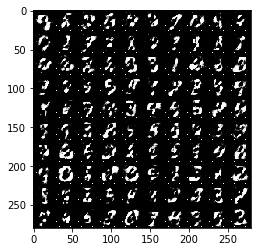

EPOCH 34 step 18600: D: loss = 0.6891667 G: loss=1.9855287 
EPOCH 34 step 18650: D: loss = 0.9517419 G: loss=1.6008093 
EPOCH 34 step 18700: D: loss = 0.9403176 G: loss=1.6236145 
EPOCH 34 step 18750: D: loss = 0.8056642 G: loss=1.9324304 
EPOCH 34 step 18800: D: loss = 0.7505576 G: loss=2.1229868 
EPOCH 34 step 18850: D: loss = 0.5537612 G: loss=2.3994696 
EPOCH 34 step 18900: D: loss = 0.4789211 G: loss=2.6507180 
EPOCH 34 step 18950: D: loss = 0.6541907 G: loss=2.2322111 
EPOCH 34 step 19000: D: loss = 0.5328273 G: loss=2.3162487 
EPOCH 34 step 19050: D: loss = 0.5335715 G: loss=2.6505098 
EPOCH 34 step 19100: D: loss = 0.4063977 G: loss=2.5018086 


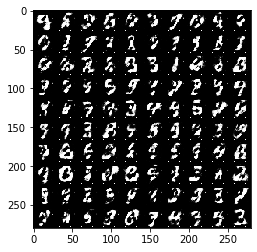

EPOCH 35 step 19150: D: loss = 0.5002480 G: loss=2.8034625 
EPOCH 35 step 19200: D: loss = 0.4591837 G: loss=2.9242067 
EPOCH 35 step 19250: D: loss = 0.4956348 G: loss=2.8410873 
EPOCH 35 step 19300: D: loss = 0.4697386 G: loss=3.2816916 
EPOCH 35 step 19350: D: loss = 0.3634825 G: loss=3.3944566 
EPOCH 35 step 19400: D: loss = 0.3327852 G: loss=3.3459678 
EPOCH 35 step 19450: D: loss = 0.3908836 G: loss=3.0725672 
EPOCH 35 step 19500: D: loss = 0.3506046 G: loss=3.0448103 
EPOCH 35 step 19550: D: loss = 0.3730697 G: loss=3.2413576 
EPOCH 35 step 19600: D: loss = 0.6576259 G: loss=2.2019632 
EPOCH 35 step 19650: D: loss = 0.7804319 G: loss=2.4011531 


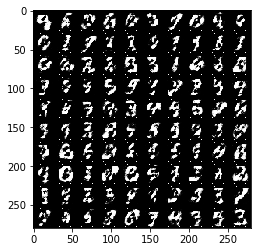

EPOCH 36 step 19700: D: loss = 1.0819126 G: loss=1.9028378 
EPOCH 36 step 19750: D: loss = 0.8766727 G: loss=2.0021687 
EPOCH 36 step 19800: D: loss = 0.7777673 G: loss=1.9641382 
EPOCH 36 step 19850: D: loss = 0.7097504 G: loss=2.0221317 
EPOCH 36 step 19900: D: loss = 0.5838916 G: loss=2.0386572 
EPOCH 36 step 19950: D: loss = 0.5871595 G: loss=2.3854067 
EPOCH 36 step 20000: D: loss = 0.5834093 G: loss=2.2406044 
EPOCH 36 step 20050: D: loss = 0.6162467 G: loss=1.9512860 
EPOCH 36 step 20100: D: loss = 0.6888737 G: loss=1.8439529 
EPOCH 36 step 20150: D: loss = 0.7155910 G: loss=1.9833405 
EPOCH 36 step 20200: D: loss = 0.7974136 G: loss=1.8055084 


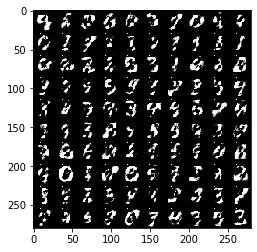

EPOCH 37 step 20250: D: loss = 0.7688225 G: loss=1.8478451 
EPOCH 37 step 20300: D: loss = 0.6581318 G: loss=1.8459486 
EPOCH 37 step 20350: D: loss = 0.6177717 G: loss=2.1936388 
EPOCH 37 step 20400: D: loss = 0.5630978 G: loss=2.0887246 
EPOCH 37 step 20450: D: loss = 0.4651204 G: loss=2.2987311 
EPOCH 37 step 20500: D: loss = 0.5954853 G: loss=2.0085690 
EPOCH 37 step 20550: D: loss = 1.1516216 G: loss=1.3388592 
EPOCH 37 step 20600: D: loss = 0.8944005 G: loss=1.4631352 
EPOCH 37 step 20650: D: loss = 0.7391433 G: loss=1.7981923 
EPOCH 37 step 20700: D: loss = 0.6922047 G: loss=1.8429151 


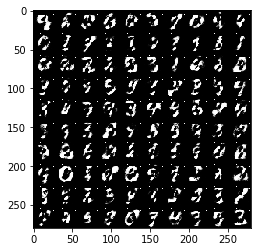

EPOCH 38 step 20750: D: loss = 0.5380141 G: loss=2.1323540 
EPOCH 38 step 20800: D: loss = 0.4364793 G: loss=2.3299007 
EPOCH 38 step 20850: D: loss = 1.4959500 G: loss=1.2106578 
EPOCH 38 step 20900: D: loss = 1.4951026 G: loss=1.0748118 
EPOCH 38 step 20950: D: loss = 1.1512347 G: loss=1.3535205 
EPOCH 38 step 21000: D: loss = 0.9601363 G: loss=1.5637894 
EPOCH 38 step 21050: D: loss = 0.6315820 G: loss=1.8290721 
EPOCH 38 step 21100: D: loss = 0.5923914 G: loss=2.0032442 
EPOCH 38 step 21150: D: loss = 0.4558357 G: loss=2.3556614 
EPOCH 38 step 21200: D: loss = 0.3435950 G: loss=2.5217428 
EPOCH 38 step 21250: D: loss = 0.3027408 G: loss=2.7205403 


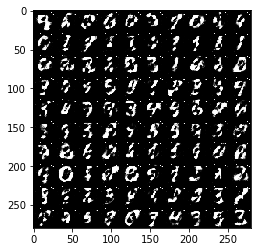

EPOCH 39 step 21300: D: loss = 0.8075468 G: loss=1.8304894 
EPOCH 39 step 21350: D: loss = 0.7396715 G: loss=1.9479795 
EPOCH 39 step 21400: D: loss = 0.6050851 G: loss=2.0395405 
EPOCH 39 step 21450: D: loss = 0.5678223 G: loss=2.1435583 
EPOCH 39 step 21500: D: loss = 0.5055964 G: loss=2.1902013 
EPOCH 39 step 21550: D: loss = 0.5045287 G: loss=2.1176112 
EPOCH 39 step 21600: D: loss = 0.4561970 G: loss=2.4015095 
EPOCH 39 step 21650: D: loss = 0.4411362 G: loss=2.2633309 
EPOCH 39 step 21700: D: loss = 0.5361723 G: loss=1.9393573 
EPOCH 39 step 21750: D: loss = 0.5830938 G: loss=2.1731052 
EPOCH 39 step 21800: D: loss = 0.7127270 G: loss=1.7959000 


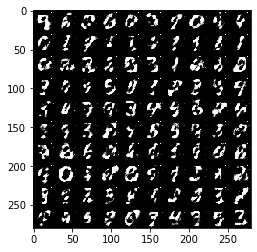

EPOCH 40 step 21850: D: loss = 0.6944363 G: loss=1.9152479 
EPOCH 40 step 21900: D: loss = 0.4893299 G: loss=2.2866104 
EPOCH 40 step 21950: D: loss = 0.5093323 G: loss=2.0631695 
EPOCH 40 step 22000: D: loss = 0.3912805 G: loss=2.3297036 
EPOCH 40 step 22050: D: loss = 0.5257118 G: loss=2.1863055 
EPOCH 40 step 22100: D: loss = 0.4943283 G: loss=2.2549934 
EPOCH 40 step 22150: D: loss = 1.9122037 G: loss=0.7634324 
EPOCH 40 step 22200: D: loss = 4.5437975 G: loss=0.3208335 
EPOCH 40 step 22250: D: loss = 3.5174308 G: loss=0.4088866 
EPOCH 40 step 22300: D: loss = 2.4124327 G: loss=0.5528768 
EPOCH 40 step 22350: D: loss = 1.2003075 G: loss=0.9835961 


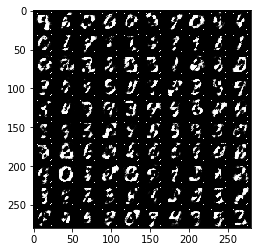

EPOCH 41 step 22400: D: loss = 0.8768049 G: loss=1.3960346 
EPOCH 41 step 22450: D: loss = 0.6848747 G: loss=1.6188149 
EPOCH 41 step 22500: D: loss = 0.5377786 G: loss=1.8765484 
EPOCH 41 step 22550: D: loss = 0.4592133 G: loss=2.0246811 
EPOCH 41 step 22600: D: loss = 0.3826782 G: loss=2.2104194 
EPOCH 41 step 22650: D: loss = 1.1033844 G: loss=1.1465032 
EPOCH 41 step 22700: D: loss = 0.5789949 G: loss=1.7977264 
EPOCH 41 step 22750: D: loss = 0.4836122 G: loss=1.8431821 
EPOCH 41 step 22800: D: loss = 0.8502771 G: loss=1.4252388 
EPOCH 41 step 22850: D: loss = 0.7595634 G: loss=1.5241501 
EPOCH 41 step 22900: D: loss = 0.6788395 G: loss=1.5477502 


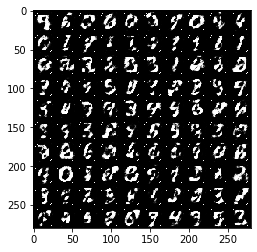

EPOCH 42 step 22950: D: loss = 0.5662715 G: loss=1.8477125 
EPOCH 42 step 23000: D: loss = 0.4008951 G: loss=2.0526993 
EPOCH 42 step 23050: D: loss = 0.3388031 G: loss=2.2968678 
EPOCH 42 step 23100: D: loss = 0.3464270 G: loss=2.2542095 
EPOCH 42 step 23150: D: loss = 0.2383741 G: loss=2.6903286 
EPOCH 42 step 23200: D: loss = 0.2595388 G: loss=2.4508123 
EPOCH 42 step 23250: D: loss = 0.3698823 G: loss=1.9839470 
EPOCH 42 step 23300: D: loss = 0.3538681 G: loss=2.1659322 
EPOCH 42 step 23350: D: loss = 0.3871481 G: loss=2.1201117 
EPOCH 42 step 23400: D: loss = 0.2963455 G: loss=2.2622082 
EPOCH 42 step 23450: D: loss = 0.4913205 G: loss=1.9894453 


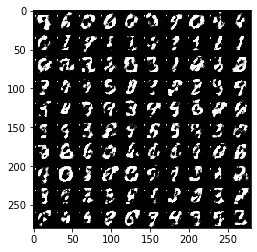

EPOCH 43 step 23500: D: loss = 0.6243525 G: loss=1.5585833 
EPOCH 43 step 23550: D: loss = 0.4642788 G: loss=1.9507161 
EPOCH 43 step 23600: D: loss = 0.4182405 G: loss=1.9988220 
EPOCH 43 step 23650: D: loss = 0.3416496 G: loss=2.2479148 
EPOCH 43 step 23700: D: loss = 0.3569945 G: loss=2.3249984 
EPOCH 43 step 23750: D: loss = 0.3648232 G: loss=2.0522332 
EPOCH 43 step 23800: D: loss = 0.7108116 G: loss=1.5156775 
EPOCH 43 step 23850: D: loss = 0.8004637 G: loss=1.3332694 
EPOCH 43 step 23900: D: loss = 0.8381399 G: loss=1.3774267 
EPOCH 43 step 23950: D: loss = 0.5966771 G: loss=1.6296136 
EPOCH 43 step 24000: D: loss = 0.7651012 G: loss=1.4002007 


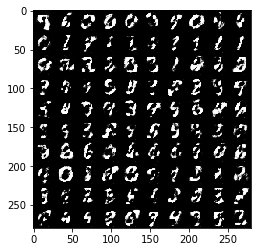

EPOCH 44 step 24050: D: loss = 0.7244353 G: loss=1.4728827 
EPOCH 44 step 24100: D: loss = 0.6121787 G: loss=1.5732691 
EPOCH 44 step 24150: D: loss = 0.6839158 G: loss=1.4638518 
EPOCH 44 step 24200: D: loss = 0.6975206 G: loss=1.5328157 
EPOCH 44 step 24250: D: loss = 0.6637059 G: loss=1.5783103 
EPOCH 44 step 24300: D: loss = 0.6360481 G: loss=1.5981637 
EPOCH 44 step 24350: D: loss = 0.6093723 G: loss=1.5661545 
EPOCH 44 step 24400: D: loss = 0.6630418 G: loss=1.6377339 
EPOCH 44 step 24450: D: loss = 0.7011048 G: loss=1.4894881 
EPOCH 44 step 24500: D: loss = 0.9655541 G: loss=1.3207284 
EPOCH 44 step 24550: D: loss = 0.7489334 G: loss=1.4390918 


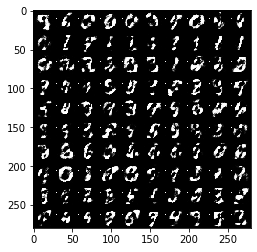

EPOCH 45 step 24600: D: loss = 0.7006664 G: loss=1.4724209 
EPOCH 45 step 24650: D: loss = 0.6251373 G: loss=1.6840855 
EPOCH 45 step 24700: D: loss = 0.5778857 G: loss=1.7027123 
EPOCH 45 step 24750: D: loss = 0.5440228 G: loss=1.8507776 
EPOCH 45 step 24800: D: loss = 0.5442091 G: loss=1.8061695 
EPOCH 45 step 24850: D: loss = 0.5377231 G: loss=1.9650065 
EPOCH 45 step 24900: D: loss = 0.4720333 G: loss=2.0885477 
EPOCH 45 step 24950: D: loss = 0.6618178 G: loss=1.6838933 
EPOCH 45 step 25000: D: loss = 0.7662487 G: loss=1.7480216 
EPOCH 45 step 25050: D: loss = 0.6346887 G: loss=1.7418294 
EPOCH 45 step 25100: D: loss = 0.6136171 G: loss=1.7581296 


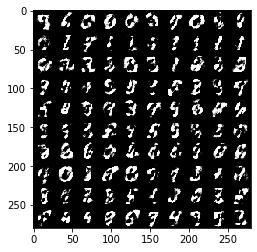

EPOCH 46 step 25150: D: loss = 0.7625753 G: loss=1.6034679 
EPOCH 46 step 25200: D: loss = 0.6379240 G: loss=1.6953729 
EPOCH 46 step 25250: D: loss = 0.5743562 G: loss=1.7080191 
EPOCH 46 step 25300: D: loss = 0.5404052 G: loss=1.9763830 
EPOCH 46 step 25350: D: loss = 0.6802830 G: loss=1.7652237 
EPOCH 46 step 25400: D: loss = 0.6524721 G: loss=1.7913874 
EPOCH 46 step 25450: D: loss = 0.7110473 G: loss=1.6950638 
EPOCH 46 step 25500: D: loss = 0.5206278 G: loss=1.9038446 
EPOCH 46 step 25550: D: loss = 0.6153178 G: loss=1.7216214 
EPOCH 46 step 25600: D: loss = 0.6496396 G: loss=1.8299165 
EPOCH 46 step 25650: D: loss = 0.7270010 G: loss=1.6665759 


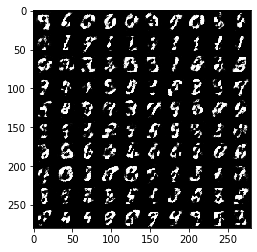

EPOCH 47 step 25700: D: loss = 0.5294464 G: loss=1.7499182 
EPOCH 47 step 25750: D: loss = 0.6764629 G: loss=1.7313402 
EPOCH 47 step 25800: D: loss = 0.6187693 G: loss=1.6966250 
EPOCH 47 step 25850: D: loss = 0.6384541 G: loss=1.6699731 
EPOCH 47 step 25900: D: loss = 1.5939763 G: loss=0.9881830 
EPOCH 47 step 25950: D: loss = 1.3770931 G: loss=1.0620451 
EPOCH 47 step 26000: D: loss = 1.2621702 G: loss=1.0645673 
EPOCH 47 step 26050: D: loss = 1.0820580 G: loss=1.1555871 
EPOCH 47 step 26100: D: loss = 0.8828386 G: loss=1.3097456 
EPOCH 47 step 26150: D: loss = 0.9913178 G: loss=1.2374090 
EPOCH 47 step 26200: D: loss = 1.5112514 G: loss=0.9041516 


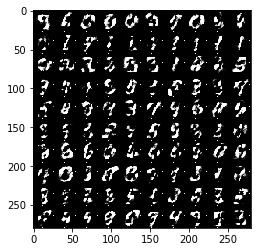

EPOCH 48 step 26250: D: loss = 1.1134982 G: loss=1.2509865 
EPOCH 48 step 26300: D: loss = 0.9733645 G: loss=1.2833611 
EPOCH 48 step 26350: D: loss = 0.6952903 G: loss=1.6299109 
EPOCH 48 step 26400: D: loss = 0.5880271 G: loss=1.7711183 
EPOCH 48 step 26450: D: loss = 0.5120857 G: loss=1.8765360 
EPOCH 48 step 26500: D: loss = 0.4173535 G: loss=1.8928374 
EPOCH 48 step 26550: D: loss = 0.3731770 G: loss=2.1932271 
EPOCH 48 step 26600: D: loss = 0.4180756 G: loss=2.2392626 
EPOCH 48 step 26650: D: loss = 0.4589026 G: loss=2.0699136 
EPOCH 48 step 26700: D: loss = 0.5066619 G: loss=1.9356514 
EPOCH 48 step 26750: D: loss = 0.4336643 G: loss=1.9666705 


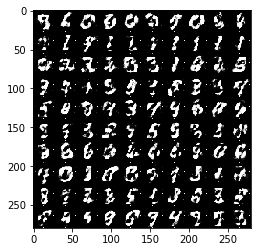

EPOCH 49 step 26800: D: loss = 0.4783676 G: loss=1.9904865 
EPOCH 49 step 26850: D: loss = 0.4981891 G: loss=2.1146488 
EPOCH 49 step 26900: D: loss = 0.5509540 G: loss=1.7938460 
EPOCH 49 step 26950: D: loss = 0.6590092 G: loss=1.6892631 
EPOCH 49 step 27000: D: loss = 0.6058354 G: loss=1.6790907 
EPOCH 49 step 27050: D: loss = 0.6572344 G: loss=1.5821559 
EPOCH 49 step 27100: D: loss = 0.5814260 G: loss=1.7195045 
EPOCH 49 step 27150: D: loss = 0.6502827 G: loss=1.6758850 
EPOCH 49 step 27200: D: loss = 0.6581405 G: loss=1.7759832 
EPOCH 49 step 27250: D: loss = 0.5292732 G: loss=1.8187664 
EPOCH 49 step 27300: D: loss = 0.6492692 G: loss=1.6485733 


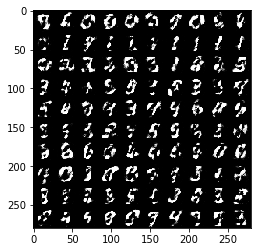

EPOCH 50 step 27350: D: loss = 0.5963327 G: loss=1.6361372 
EPOCH 50 step 27400: D: loss = 0.5449704 G: loss=1.8425577 
EPOCH 50 step 27450: D: loss = 0.6768720 G: loss=1.5943420 
EPOCH 50 step 27500: D: loss = 0.6030412 G: loss=1.6988733 
EPOCH 50 step 27550: D: loss = 0.6755520 G: loss=1.6251068 
EPOCH 50 step 27600: D: loss = 1.5500138 G: loss=0.8869512 
EPOCH 50 step 27650: D: loss = 1.3725779 G: loss=0.9591918 
EPOCH 50 step 27700: D: loss = 1.3596750 G: loss=1.0197785 
EPOCH 50 step 27750: D: loss = 1.0368743 G: loss=1.0723287 
EPOCH 50 step 27800: D: loss = 1.0067259 G: loss=1.1982208 


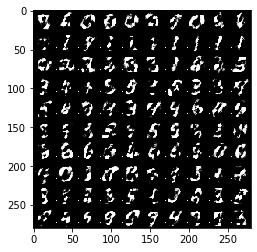

EPOCH 51 step 27850: D: loss = 0.9055925 G: loss=1.3605721 
EPOCH 51 step 27900: D: loss = 0.7226791 G: loss=1.5050802 
EPOCH 51 step 27950: D: loss = 0.7513772 G: loss=1.5295577 
EPOCH 51 step 28000: D: loss = 0.7403966 G: loss=1.6047120 
EPOCH 51 step 28050: D: loss = 0.6788795 G: loss=1.7627033 
EPOCH 51 step 28100: D: loss = 0.6173414 G: loss=1.7879720 
EPOCH 51 step 28150: D: loss = 0.6774333 G: loss=1.6523604 
EPOCH 51 step 28200: D: loss = 0.4974880 G: loss=1.8841984 
EPOCH 51 step 28250: D: loss = 0.5674130 G: loss=1.9021429 
EPOCH 51 step 28300: D: loss = 0.5568237 G: loss=1.8637277 
EPOCH 51 step 28350: D: loss = 0.5438439 G: loss=1.9843770 


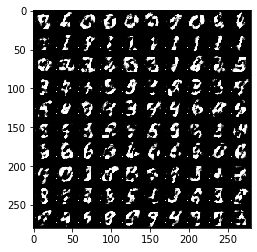

EPOCH 52 step 28400: D: loss = 0.4987499 G: loss=1.9504960 
EPOCH 52 step 28450: D: loss = 0.4959866 G: loss=1.9611285 
EPOCH 52 step 28500: D: loss = 0.4297427 G: loss=2.0266707 
EPOCH 52 step 28550: D: loss = 0.4550249 G: loss=2.0708101 
EPOCH 52 step 28600: D: loss = 0.3957593 G: loss=2.1208973 
EPOCH 52 step 28650: D: loss = 0.6224011 G: loss=1.7859251 
EPOCH 52 step 28700: D: loss = 0.6545094 G: loss=1.6996521 
EPOCH 52 step 28750: D: loss = 0.7484732 G: loss=1.5255359 
EPOCH 52 step 28800: D: loss = 0.6672090 G: loss=1.5630617 
EPOCH 52 step 28850: D: loss = 0.6649454 G: loss=1.6243117 
EPOCH 52 step 28900: D: loss = 1.2102014 G: loss=1.0751896 


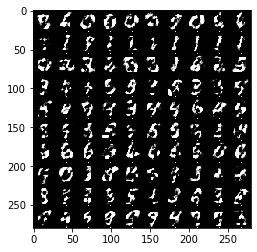

EPOCH 53 step 28950: D: loss = 1.0395372 G: loss=1.3014655 
EPOCH 53 step 29000: D: loss = 0.7507804 G: loss=1.4101381 
EPOCH 53 step 29050: D: loss = 0.7422137 G: loss=1.6392541 
EPOCH 53 step 29100: D: loss = 0.7728942 G: loss=1.5338815 
EPOCH 53 step 29150: D: loss = 0.6062666 G: loss=1.5931709 
EPOCH 53 step 29200: D: loss = 0.5025647 G: loss=1.8040911 
EPOCH 53 step 29250: D: loss = 0.4944159 G: loss=1.7801096 
EPOCH 53 step 29300: D: loss = 0.6890852 G: loss=1.6155555 
EPOCH 53 step 29350: D: loss = 0.7840421 G: loss=1.4504128 
EPOCH 53 step 29400: D: loss = 0.6758707 G: loss=1.5749220 
EPOCH 53 step 29450: D: loss = 0.7735162 G: loss=1.5088319 


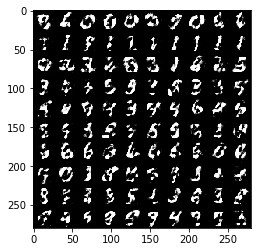

EPOCH 54 step 29500: D: loss = 0.6766164 G: loss=1.6374229 
EPOCH 54 step 29550: D: loss = 0.7574644 G: loss=1.5422943 
EPOCH 54 step 29600: D: loss = 0.6757410 G: loss=1.6257513 
EPOCH 54 step 29650: D: loss = 0.6817671 G: loss=1.5397700 
EPOCH 54 step 29700: D: loss = 1.9589860 G: loss=0.7065302 
EPOCH 54 step 29750: D: loss = 1.8966982 G: loss=0.6792896 
EPOCH 54 step 29800: D: loss = 1.4423108 G: loss=0.9047842 
EPOCH 54 step 29850: D: loss = 1.2391067 G: loss=0.9459568 
EPOCH 54 step 29900: D: loss = 1.1258540 G: loss=1.0699126 
EPOCH 54 step 29950: D: loss = 1.1656975 G: loss=1.0891484 
EPOCH 54 step 30000: D: loss = 1.8843331 G: loss=0.6625974 


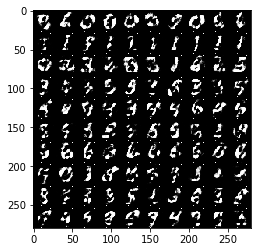

EPOCH 55 step 30050: D: loss = 1.3907319 G: loss=0.8606744 
EPOCH 55 step 30100: D: loss = 1.1141815 G: loss=1.1039519 
EPOCH 55 step 30150: D: loss = 0.8305441 G: loss=1.2631425 
EPOCH 55 step 30200: D: loss = 0.6829070 G: loss=1.4914300 
EPOCH 55 step 30250: D: loss = 0.6387060 G: loss=1.5535131 
EPOCH 55 step 30300: D: loss = 0.4989189 G: loss=1.8280623 
EPOCH 55 step 30350: D: loss = 0.4392751 G: loss=1.9481685 
EPOCH 55 step 30400: D: loss = 0.3750693 G: loss=2.0553331 
EPOCH 55 step 30450: D: loss = 0.4954680 G: loss=1.8234941 
EPOCH 55 step 30500: D: loss = 0.6047029 G: loss=1.5693293 
EPOCH 55 step 30550: D: loss = 0.4800804 G: loss=1.7953582 


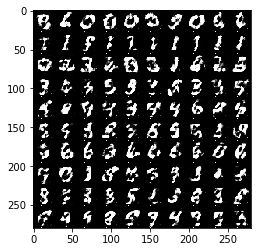

EPOCH 56 step 30600: D: loss = 0.6609867 G: loss=1.5635420 
EPOCH 56 step 30650: D: loss = 0.6731673 G: loss=1.5047584 
EPOCH 56 step 30700: D: loss = 0.7328150 G: loss=1.4726933 
EPOCH 56 step 30750: D: loss = 0.7990655 G: loss=1.3556657 
EPOCH 56 step 30800: D: loss = 0.7051965 G: loss=1.4181006 
EPOCH 56 step 30850: D: loss = 0.8882123 G: loss=1.2958975 
EPOCH 56 step 30900: D: loss = 2.7126207 G: loss=0.4082326 
EPOCH 56 step 30950: D: loss = 2.7413719 G: loss=0.3451891 
EPOCH 56 step 31000: D: loss = 1.7903529 G: loss=0.5897785 
EPOCH 56 step 31050: D: loss = 1.6936356 G: loss=0.5996885 
EPOCH 56 step 31100: D: loss = 1.4473066 G: loss=0.7550343 


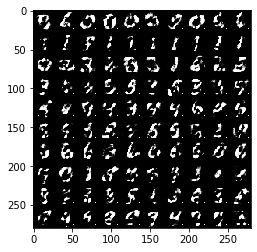

EPOCH 57 step 31150: D: loss = 1.4042073 G: loss=0.7520477 
EPOCH 57 step 31200: D: loss = 1.2632244 G: loss=0.8530958 
EPOCH 57 step 31250: D: loss = 1.0770879 G: loss=1.0642354 
EPOCH 57 step 31300: D: loss = 0.9941590 G: loss=1.1556025 
EPOCH 57 step 31350: D: loss = 0.9198819 G: loss=1.1809311 
EPOCH 57 step 31400: D: loss = 0.9092833 G: loss=1.2043574 
EPOCH 57 step 31450: D: loss = 0.7910103 G: loss=1.3429096 
EPOCH 57 step 31500: D: loss = 0.7765826 G: loss=1.3927225 
EPOCH 57 step 31550: D: loss = 0.6797143 G: loss=1.4908102 
EPOCH 57 step 31600: D: loss = 0.6397883 G: loss=1.5256010 
EPOCH 57 step 31650: D: loss = 0.6678460 G: loss=1.5461978 


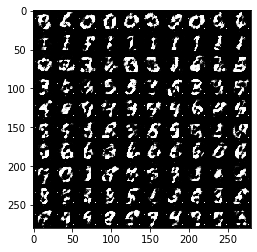

EPOCH 58 step 31700: D: loss = 0.6052142 G: loss=1.6600415 
EPOCH 58 step 31750: D: loss = 0.5656812 G: loss=1.6103582 
EPOCH 58 step 31800: D: loss = 0.5472559 G: loss=1.7194384 
EPOCH 58 step 31850: D: loss = 0.5279521 G: loss=1.6487132 
EPOCH 58 step 31900: D: loss = 0.5227094 G: loss=1.6921967 
EPOCH 58 step 31950: D: loss = 0.6042548 G: loss=1.6079975 
EPOCH 58 step 32000: D: loss = 0.8129725 G: loss=1.2759428 
EPOCH 58 step 32050: D: loss = 0.7745730 G: loss=1.2596865 
EPOCH 58 step 32100: D: loss = 0.8903009 G: loss=1.1789793 
EPOCH 58 step 32150: D: loss = 0.8695129 G: loss=1.2462144 
EPOCH 58 step 32200: D: loss = 0.7682530 G: loss=1.3049020 


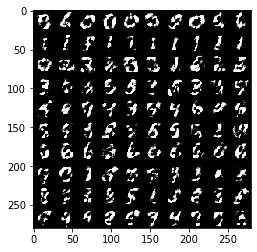

EPOCH 59 step 32250: D: loss = 0.8740253 G: loss=1.2566657 
EPOCH 59 step 32300: D: loss = 0.8195728 G: loss=1.2047472 
EPOCH 59 step 32350: D: loss = 0.8683192 G: loss=1.2512982 
EPOCH 59 step 32400: D: loss = 0.8408818 G: loss=1.4129763 
EPOCH 59 step 32450: D: loss = 0.8192726 G: loss=1.2826622 
EPOCH 59 step 32500: D: loss = 0.8274814 G: loss=1.3840443 
EPOCH 59 step 32550: D: loss = 0.7841290 G: loss=1.3028024 
EPOCH 59 step 32600: D: loss = 0.7957196 G: loss=1.3521136 
EPOCH 59 step 32650: D: loss = 0.7640445 G: loss=1.3656933 
EPOCH 59 step 32700: D: loss = 0.7013749 G: loss=1.4863443 
EPOCH 59 step 32750: D: loss = 0.8612944 G: loss=1.1975827 


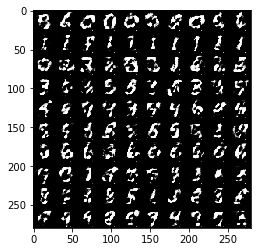

EPOCH 60 step 32800: D: loss = 0.6685799 G: loss=1.5277532 
EPOCH 60 step 32850: D: loss = 0.7731743 G: loss=1.3694950 
EPOCH 60 step 32900: D: loss = 0.7139970 G: loss=1.4860258 
EPOCH 60 step 32950: D: loss = 0.7699262 G: loss=1.4302831 
EPOCH 60 step 33000: D: loss = 0.7719557 G: loss=1.4805453 
EPOCH 60 step 33050: D: loss = 0.7799902 G: loss=1.3863149 
EPOCH 60 step 33100: D: loss = 0.7911197 G: loss=1.3733759 
EPOCH 60 step 33150: D: loss = 0.7379400 G: loss=1.5169740 
EPOCH 60 step 33200: D: loss = 0.7230282 G: loss=1.5152085 
EPOCH 60 step 33250: D: loss = 0.7516346 G: loss=1.4757428 
EPOCH 60 step 33300: D: loss = 0.6450480 G: loss=1.5612350 


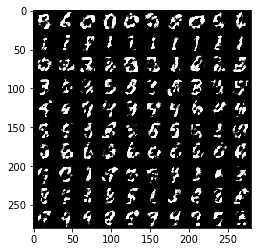

EPOCH 61 step 33350: D: loss = 0.6673248 G: loss=1.5358654 
EPOCH 61 step 33400: D: loss = 0.7015796 G: loss=1.4691097 
EPOCH 61 step 33450: D: loss = 0.6736255 G: loss=1.6217248 
EPOCH 61 step 33500: D: loss = 0.7327098 G: loss=1.5081694 
EPOCH 61 step 33550: D: loss = 0.6783311 G: loss=1.5219774 
EPOCH 61 step 33600: D: loss = 0.8112283 G: loss=1.5132102 
EPOCH 61 step 33650: D: loss = 0.7391273 G: loss=1.5836656 
EPOCH 61 step 33700: D: loss = 0.6377671 G: loss=1.6058366 
EPOCH 61 step 33750: D: loss = 0.7522236 G: loss=1.5067428 
EPOCH 61 step 33800: D: loss = 0.7388517 G: loss=1.5751718 
EPOCH 61 step 33850: D: loss = 0.6730325 G: loss=1.6359284 


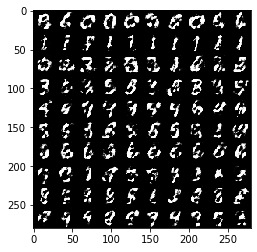

EPOCH 62 step 33900: D: loss = 0.7214785 G: loss=1.6249642 
EPOCH 62 step 33950: D: loss = 0.6830962 G: loss=1.5514584 
EPOCH 62 step 34000: D: loss = 0.7446475 G: loss=1.5283291 
EPOCH 62 step 34050: D: loss = 0.7572019 G: loss=1.5874777 
EPOCH 62 step 34100: D: loss = 0.6702202 G: loss=1.5563138 
EPOCH 62 step 34150: D: loss = 0.8078265 G: loss=1.4925876 
EPOCH 62 step 34200: D: loss = 0.7578096 G: loss=1.5181895 
EPOCH 62 step 34250: D: loss = 0.7421768 G: loss=1.6260853 
EPOCH 62 step 34300: D: loss = 0.7307968 G: loss=1.5724138 
EPOCH 62 step 34350: D: loss = 0.6424437 G: loss=1.6358123 


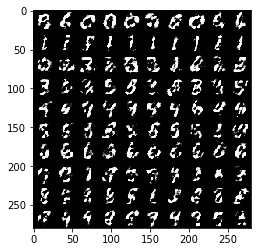

EPOCH 63 step 34400: D: loss = 0.7185535 G: loss=1.4591799 
EPOCH 63 step 34450: D: loss = 0.7651894 G: loss=1.6309278 
EPOCH 63 step 34500: D: loss = 0.7050765 G: loss=1.6539871 
EPOCH 63 step 34550: D: loss = 0.6636442 G: loss=1.6612008 
EPOCH 63 step 34600: D: loss = 0.6448061 G: loss=1.5827458 
EPOCH 63 step 34650: D: loss = 0.6890057 G: loss=1.5683775 
EPOCH 63 step 34700: D: loss = 0.7539786 G: loss=1.5428622 
EPOCH 63 step 34750: D: loss = 0.7411710 G: loss=1.4667611 
EPOCH 63 step 34800: D: loss = 0.7277587 G: loss=1.6333883 
EPOCH 63 step 34850: D: loss = 0.6888662 G: loss=1.6243417 
EPOCH 63 step 34900: D: loss = 0.6558942 G: loss=1.5198182 


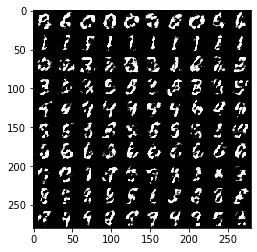

EPOCH 64 step 34950: D: loss = 0.6598189 G: loss=1.6161835 
EPOCH 64 step 35000: D: loss = 0.7359312 G: loss=1.5184349 
EPOCH 64 step 35050: D: loss = 0.6950732 G: loss=1.5813649 
EPOCH 64 step 35100: D: loss = 0.6603214 G: loss=1.6210819 
EPOCH 64 step 35150: D: loss = 0.7018677 G: loss=1.6006565 
EPOCH 64 step 35200: D: loss = 0.7168816 G: loss=1.6097348 
EPOCH 64 step 35250: D: loss = 0.6749126 G: loss=1.6657457 
EPOCH 64 step 35300: D: loss = 0.6673307 G: loss=1.6453762 
EPOCH 64 step 35350: D: loss = 0.6214739 G: loss=1.6774753 
EPOCH 64 step 35400: D: loss = 0.7055172 G: loss=1.5936283 
EPOCH 64 step 35450: D: loss = 0.6468787 G: loss=1.7593197 


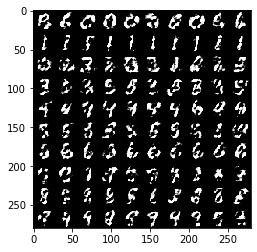

EPOCH 65 step 35500: D: loss = 0.7221082 G: loss=1.6046175 
EPOCH 65 step 35550: D: loss = 0.5867661 G: loss=1.7695856 
EPOCH 65 step 35600: D: loss = 0.6772525 G: loss=1.6053008 
EPOCH 65 step 35650: D: loss = 0.6944256 G: loss=1.5649443 
EPOCH 65 step 35700: D: loss = 0.7667922 G: loss=1.5828466 
EPOCH 65 step 35750: D: loss = 0.6682780 G: loss=1.6616267 
EPOCH 65 step 35800: D: loss = 0.7648741 G: loss=1.5526155 
EPOCH 65 step 35850: D: loss = 0.5550240 G: loss=1.7536887 
EPOCH 65 step 35900: D: loss = 0.8011980 G: loss=1.5860128 
EPOCH 65 step 35950: D: loss = 0.7205526 G: loss=1.5290585 
EPOCH 65 step 36000: D: loss = 0.6561332 G: loss=1.7455211 


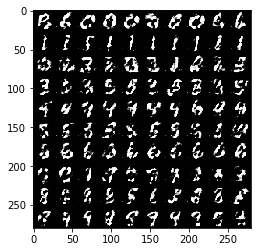

EPOCH 66 step 36050: D: loss = 0.6531242 G: loss=1.6530952 
EPOCH 66 step 36100: D: loss = 0.6384428 G: loss=1.7283982 
EPOCH 66 step 36150: D: loss = 0.6522703 G: loss=1.7214985 
EPOCH 66 step 36200: D: loss = 0.7299646 G: loss=1.6682365 
EPOCH 66 step 36250: D: loss = 0.6154652 G: loss=1.6930633 
EPOCH 66 step 36300: D: loss = 0.6522563 G: loss=1.6497310 
EPOCH 66 step 36350: D: loss = 0.6189066 G: loss=1.6672854 
EPOCH 66 step 36400: D: loss = 0.5827004 G: loss=1.7315326 
EPOCH 66 step 36450: D: loss = 0.5855582 G: loss=1.7704239 
EPOCH 66 step 36500: D: loss = 0.7159437 G: loss=1.6236429 
EPOCH 66 step 36550: D: loss = 0.6022570 G: loss=1.7370234 


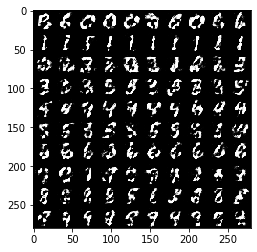

EPOCH 67 step 36600: D: loss = 0.7020206 G: loss=1.6104708 
EPOCH 67 step 36650: D: loss = 0.6596167 G: loss=1.7829926 
EPOCH 67 step 36700: D: loss = 0.5606982 G: loss=1.8738317 
EPOCH 67 step 36750: D: loss = 0.7067730 G: loss=1.7479378 
EPOCH 67 step 36800: D: loss = 0.7585334 G: loss=1.5692177 
EPOCH 67 step 36850: D: loss = 1.3114645 G: loss=1.1795331 
EPOCH 67 step 36900: D: loss = 1.2386318 G: loss=1.0960505 
EPOCH 67 step 36950: D: loss = 0.9977119 G: loss=1.2110155 
EPOCH 67 step 37000: D: loss = 0.7426043 G: loss=1.5253886 
EPOCH 67 step 37050: D: loss = 0.7896219 G: loss=1.4485743 
EPOCH 67 step 37100: D: loss = 0.7782100 G: loss=1.4854538 


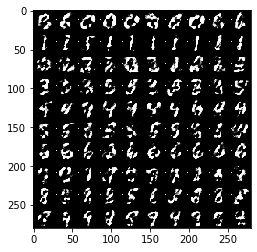

EPOCH 68 step 37150: D: loss = 0.6376243 G: loss=1.6464863 
EPOCH 68 step 37200: D: loss = 0.5278254 G: loss=1.7942976 
EPOCH 68 step 37250: D: loss = 0.5631196 G: loss=1.7431414 
EPOCH 68 step 37300: D: loss = 0.5219349 G: loss=1.8188846 
EPOCH 68 step 37350: D: loss = 0.5341934 G: loss=1.8537967 
EPOCH 68 step 37400: D: loss = 0.4201896 G: loss=1.9511545 
EPOCH 68 step 37450: D: loss = 0.4359951 G: loss=1.9926174 
EPOCH 68 step 37500: D: loss = 0.5153289 G: loss=1.8805413 
EPOCH 68 step 37550: D: loss = 0.6964296 G: loss=1.6040779 
EPOCH 68 step 37600: D: loss = 0.6386141 G: loss=1.6817747 
EPOCH 68 step 37650: D: loss = 0.6291462 G: loss=1.6473653 


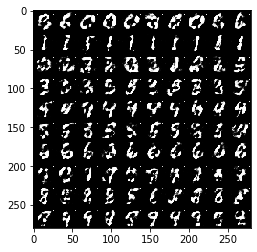

EPOCH 69 step 37700: D: loss = 0.6766957 G: loss=1.6193618 
EPOCH 69 step 37750: D: loss = 0.7191931 G: loss=1.5488045 
EPOCH 69 step 37800: D: loss = 0.7087357 G: loss=1.4773695 
EPOCH 69 step 37850: D: loss = 0.6521917 G: loss=1.6905284 
EPOCH 69 step 37900: D: loss = 0.6314215 G: loss=1.6829150 
EPOCH 69 step 37950: D: loss = 0.6289047 G: loss=1.6631024 
EPOCH 69 step 38000: D: loss = 0.5948644 G: loss=1.7548051 
EPOCH 69 step 38050: D: loss = 0.7075971 G: loss=1.5777807 
EPOCH 69 step 38100: D: loss = 0.6261097 G: loss=1.6182638 
EPOCH 69 step 38150: D: loss = 0.5845989 G: loss=1.7356272 
EPOCH 69 step 38200: D: loss = 0.5707921 G: loss=1.7053421 


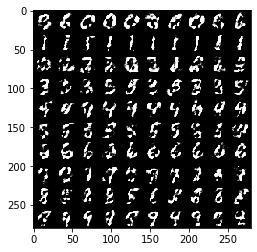

EPOCH 70 step 38250: D: loss = 0.6090533 G: loss=1.6971834 
EPOCH 70 step 38300: D: loss = 0.6071334 G: loss=1.7516448 
EPOCH 70 step 38350: D: loss = 0.7527200 G: loss=1.5313795 
EPOCH 70 step 38400: D: loss = 0.6029423 G: loss=1.7292452 
EPOCH 70 step 38450: D: loss = 0.6691432 G: loss=1.6073396 
EPOCH 70 step 38500: D: loss = 0.6568945 G: loss=1.5577148 
EPOCH 70 step 38550: D: loss = 0.6584388 G: loss=1.6641092 
EPOCH 70 step 38600: D: loss = 0.7124017 G: loss=1.6871624 
EPOCH 70 step 38650: D: loss = 0.7379415 G: loss=1.6532282 
EPOCH 70 step 38700: D: loss = 0.6868711 G: loss=1.6822777 
EPOCH 70 step 38750: D: loss = 0.6547623 G: loss=1.6737366 


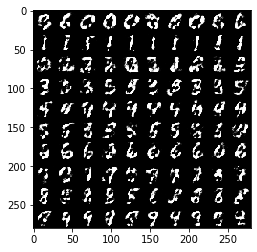

EPOCH 71 step 38800: D: loss = 0.7158396 G: loss=1.7363892 
EPOCH 71 step 38850: D: loss = 0.6267067 G: loss=1.7317580 
EPOCH 71 step 38900: D: loss = 0.6956564 G: loss=1.6278906 
EPOCH 71 step 38950: D: loss = 0.6586412 G: loss=1.6801435 
EPOCH 71 step 39000: D: loss = 0.6358979 G: loss=1.6595757 
EPOCH 71 step 39050: D: loss = 0.5910131 G: loss=1.8756411 
EPOCH 71 step 39100: D: loss = 0.5808783 G: loss=1.6882696 
EPOCH 71 step 39150: D: loss = 0.7254663 G: loss=1.6580687 
EPOCH 71 step 39200: D: loss = 0.7139416 G: loss=1.7148767 
EPOCH 71 step 39250: D: loss = 0.5568300 G: loss=1.7672160 
EPOCH 71 step 39300: D: loss = 0.6267561 G: loss=1.8137851 


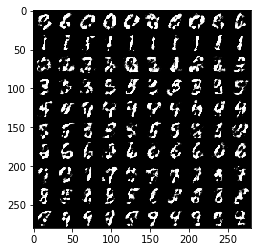

EPOCH 72 step 39350: D: loss = 0.6447518 G: loss=1.7179227 
EPOCH 72 step 39400: D: loss = 0.7233953 G: loss=1.7534347 
EPOCH 72 step 39450: D: loss = 0.6930634 G: loss=1.6253908 
EPOCH 72 step 39500: D: loss = 0.6802983 G: loss=1.6970924 
EPOCH 72 step 39550: D: loss = 0.7692755 G: loss=1.6585718 
EPOCH 72 step 39600: D: loss = 0.5491501 G: loss=1.9019194 
EPOCH 72 step 39650: D: loss = 0.6203440 G: loss=1.7966201 
EPOCH 72 step 39700: D: loss = 0.6715099 G: loss=1.5969312 
EPOCH 72 step 39750: D: loss = 2.1077168 G: loss=0.6920829 
EPOCH 72 step 39800: D: loss = 3.1632524 G: loss=0.3928972 
EPOCH 72 step 39850: D: loss = 2.7305782 G: loss=0.4482481 


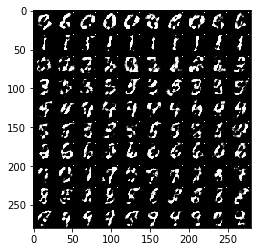

EPOCH 73 step 39900: D: loss = 2.2499337 G: loss=0.5570728 
EPOCH 73 step 39950: D: loss = 2.1999176 G: loss=0.5198238 
EPOCH 73 step 40000: D: loss = 2.0142643 G: loss=0.6242254 
EPOCH 73 step 40050: D: loss = 1.6675538 G: loss=0.7211880 
EPOCH 73 step 40100: D: loss = 1.5188484 G: loss=0.8159100 
EPOCH 73 step 40150: D: loss = 2.0114346 G: loss=0.5391578 
EPOCH 73 step 40200: D: loss = 1.2885063 G: loss=0.9696877 
EPOCH 73 step 40250: D: loss = 1.1349986 G: loss=1.0979439 
EPOCH 73 step 40300: D: loss = 1.0130076 G: loss=1.2478714 
EPOCH 73 step 40350: D: loss = 1.1368690 G: loss=1.1320314 
EPOCH 73 step 40400: D: loss = 1.1049947 G: loss=1.1580008 


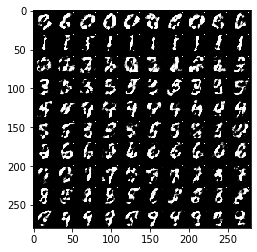

EPOCH 74 step 40450: D: loss = 0.9793081 G: loss=1.2691231 
EPOCH 74 step 40500: D: loss = 0.9956864 G: loss=1.3320401 
EPOCH 74 step 40550: D: loss = 0.8292533 G: loss=1.4762301 
EPOCH 74 step 40600: D: loss = 0.8591050 G: loss=1.4320924 
EPOCH 74 step 40650: D: loss = 0.7289339 G: loss=1.4463251 
EPOCH 74 step 40700: D: loss = 0.7762001 G: loss=1.4744650 
EPOCH 74 step 40750: D: loss = 0.7041499 G: loss=1.4665575 
EPOCH 74 step 40800: D: loss = 0.6535085 G: loss=1.4651581 
EPOCH 74 step 40850: D: loss = 0.5658664 G: loss=1.8555884 
EPOCH 74 step 40900: D: loss = 0.7104787 G: loss=1.4912558 
EPOCH 74 step 40950: D: loss = 0.5327553 G: loss=1.6902058 


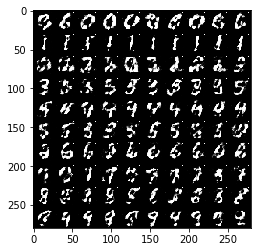

EPOCH 75 step 41000: D: loss = 0.6075231 G: loss=1.7541538 
EPOCH 75 step 41050: D: loss = 0.5410229 G: loss=1.7233913 
EPOCH 75 step 41100: D: loss = 0.4163722 G: loss=1.9935387 
EPOCH 75 step 41150: D: loss = 0.5082287 G: loss=1.7818302 
EPOCH 75 step 41200: D: loss = 0.5661617 G: loss=2.0080040 
EPOCH 75 step 41250: D: loss = 0.4578644 G: loss=1.9433588 
EPOCH 75 step 41300: D: loss = 0.4164218 G: loss=1.9635899 
EPOCH 75 step 41350: D: loss = 0.4474502 G: loss=2.1212449 
EPOCH 75 step 41400: D: loss = 0.4176747 G: loss=2.0085361 
EPOCH 75 step 41450: D: loss = 0.4104634 G: loss=1.9719665 


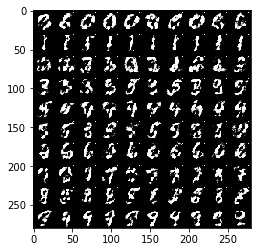

EPOCH 76 step 41500: D: loss = 0.4173679 G: loss=1.9562918 
EPOCH 76 step 41550: D: loss = 0.6400551 G: loss=1.6232203 
EPOCH 76 step 41600: D: loss = 0.7628520 G: loss=1.3880506 
EPOCH 76 step 41650: D: loss = 0.7700135 G: loss=1.4358803 
EPOCH 76 step 41700: D: loss = 0.7120500 G: loss=1.4971489 
EPOCH 76 step 41750: D: loss = 0.6890620 G: loss=1.5215354 
EPOCH 76 step 41800: D: loss = 0.7742380 G: loss=1.4255470 
EPOCH 76 step 41850: D: loss = 0.7287223 G: loss=1.5498154 
EPOCH 76 step 41900: D: loss = 0.7677003 G: loss=1.4606889 
EPOCH 76 step 41950: D: loss = 0.7907691 G: loss=1.4123768 
EPOCH 76 step 42000: D: loss = 0.7308911 G: loss=1.4577606 


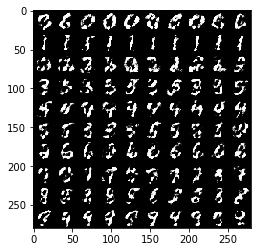

EPOCH 77 step 42050: D: loss = 0.7254390 G: loss=1.5425689 
EPOCH 77 step 42100: D: loss = 0.6934636 G: loss=1.4873083 
EPOCH 77 step 42150: D: loss = 0.6873012 G: loss=1.4351263 
EPOCH 77 step 42200: D: loss = 0.6849577 G: loss=1.4965657 
EPOCH 77 step 42250: D: loss = 0.7020005 G: loss=1.5822846 
EPOCH 77 step 42300: D: loss = 0.6728220 G: loss=1.5555732 
EPOCH 77 step 42350: D: loss = 0.6451289 G: loss=1.5450122 
EPOCH 77 step 42400: D: loss = 0.7034168 G: loss=1.5148516 
EPOCH 77 step 42450: D: loss = 0.6697844 G: loss=1.6176085 
EPOCH 77 step 42500: D: loss = 0.6439875 G: loss=1.5880616 
EPOCH 77 step 42550: D: loss = 0.6595794 G: loss=1.6510062 


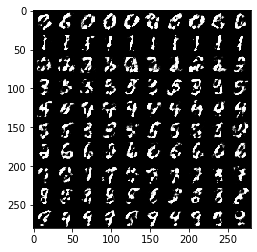

EPOCH 78 step 42600: D: loss = 0.7049361 G: loss=1.6027788 
EPOCH 78 step 42650: D: loss = 0.7073892 G: loss=1.4444969 
EPOCH 78 step 42700: D: loss = 0.5841277 G: loss=1.7389220 
EPOCH 78 step 42750: D: loss = 0.6820959 G: loss=1.5796144 
EPOCH 78 step 42800: D: loss = 0.6748791 G: loss=1.6086081 
EPOCH 78 step 42850: D: loss = 0.6296314 G: loss=1.6211579 
EPOCH 78 step 42900: D: loss = 0.6368461 G: loss=1.6482092 
EPOCH 78 step 42950: D: loss = 0.7077227 G: loss=1.7664983 
EPOCH 78 step 43000: D: loss = 0.6308046 G: loss=1.6085383 
EPOCH 78 step 43050: D: loss = 2.5211089 G: loss=0.5757066 
EPOCH 78 step 43100: D: loss = 2.0127699 G: loss=0.6576524 


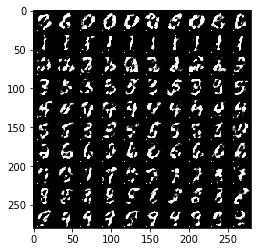

EPOCH 79 step 43150: D: loss = 1.6081921 G: loss=0.8903666 
EPOCH 79 step 43200: D: loss = 1.4384522 G: loss=0.8664787 
EPOCH 79 step 43250: D: loss = 1.2122608 G: loss=1.0156791 
EPOCH 79 step 43300: D: loss = 1.0644579 G: loss=1.1384642 
EPOCH 79 step 43350: D: loss = 1.0191784 G: loss=1.2184997 
EPOCH 79 step 43400: D: loss = 1.0503175 G: loss=1.1298196 
EPOCH 79 step 43450: D: loss = 0.7954822 G: loss=1.3905404 
EPOCH 79 step 43500: D: loss = 0.8400456 G: loss=1.2900913 
EPOCH 79 step 43550: D: loss = 0.7642373 G: loss=1.4308529 
EPOCH 79 step 43600: D: loss = 0.7269548 G: loss=1.5765636 
EPOCH 79 step 43650: D: loss = 0.6644114 G: loss=1.5787747 


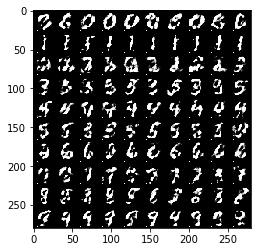

EPOCH 80 step 43700: D: loss = 0.5803771 G: loss=1.6850235 
EPOCH 80 step 43750: D: loss = 0.6336185 G: loss=1.7933384 
EPOCH 80 step 43800: D: loss = 0.5480763 G: loss=1.8194928 
EPOCH 80 step 43850: D: loss = 0.5639991 G: loss=1.7633183 
EPOCH 80 step 43900: D: loss = 0.4925701 G: loss=1.9195676 
EPOCH 80 step 43950: D: loss = 0.4898181 G: loss=1.9111860 
EPOCH 80 step 44000: D: loss = 0.4481843 G: loss=2.0302060 
EPOCH 80 step 44050: D: loss = 0.4851663 G: loss=1.9207470 
EPOCH 80 step 44100: D: loss = 0.4253708 G: loss=2.0697587 
EPOCH 80 step 44150: D: loss = 0.5976896 G: loss=1.7019881 
EPOCH 80 step 44200: D: loss = 0.7024723 G: loss=1.5752871 


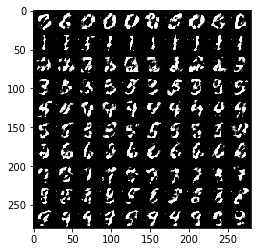

EPOCH 81 step 44250: D: loss = 0.7363801 G: loss=1.4060972 
EPOCH 81 step 44300: D: loss = 0.6315545 G: loss=1.5534847 
EPOCH 81 step 44350: D: loss = 0.6057203 G: loss=1.6976657 
EPOCH 81 step 44400: D: loss = 0.6804496 G: loss=1.5789661 
EPOCH 81 step 44450: D: loss = 0.5502023 G: loss=1.7299106 
EPOCH 81 step 44500: D: loss = 0.6689621 G: loss=1.6445378 
EPOCH 81 step 44550: D: loss = 0.7498473 G: loss=1.5529349 
EPOCH 81 step 44600: D: loss = 0.7287620 G: loss=1.4800152 
EPOCH 81 step 44650: D: loss = 0.7030312 G: loss=1.5912316 
EPOCH 81 step 44700: D: loss = 0.6013615 G: loss=1.6408205 
EPOCH 81 step 44750: D: loss = 0.7586491 G: loss=1.6548045 


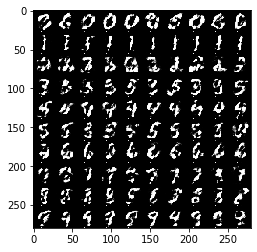

EPOCH 82 step 44800: D: loss = 0.6818166 G: loss=1.5873778 
EPOCH 82 step 44850: D: loss = 0.7207178 G: loss=1.5399643 
EPOCH 82 step 44900: D: loss = 0.6618264 G: loss=1.6906605 
EPOCH 82 step 44950: D: loss = 0.6047275 G: loss=1.7150542 
EPOCH 82 step 45000: D: loss = 0.6223252 G: loss=1.5940527 
EPOCH 82 step 45050: D: loss = 0.7211652 G: loss=1.5465382 
EPOCH 82 step 45100: D: loss = 0.6397451 G: loss=1.5726088 
EPOCH 82 step 45150: D: loss = 0.5259354 G: loss=1.8125788 
EPOCH 82 step 45200: D: loss = 0.5732162 G: loss=1.6752849 
EPOCH 82 step 45250: D: loss = 0.6548105 G: loss=1.6185695 
EPOCH 82 step 45300: D: loss = 0.6007221 G: loss=1.7706425 


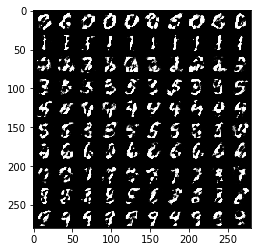

EPOCH 83 step 45350: D: loss = 0.5320314 G: loss=1.7608021 
EPOCH 83 step 45400: D: loss = 0.6879231 G: loss=1.7341137 
EPOCH 83 step 45450: D: loss = 0.6034961 G: loss=1.6873626 
EPOCH 83 step 45500: D: loss = 0.7165365 G: loss=1.6349212 
EPOCH 83 step 45550: D: loss = 0.6661395 G: loss=1.6816647 
EPOCH 83 step 45600: D: loss = 0.6474741 G: loss=1.7859402 
EPOCH 83 step 45650: D: loss = 0.6316773 G: loss=1.7085502 
EPOCH 83 step 45700: D: loss = 0.5420824 G: loss=1.7136858 
EPOCH 83 step 45750: D: loss = 0.7845913 G: loss=1.6410488 
EPOCH 83 step 45800: D: loss = 0.6140122 G: loss=1.6919258 
EPOCH 83 step 45850: D: loss = 0.6131712 G: loss=1.6674463 


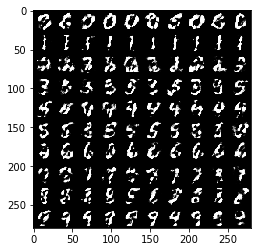

EPOCH 84 step 45900: D: loss = 0.6220709 G: loss=1.6040856 
EPOCH 84 step 45950: D: loss = 0.6011455 G: loss=1.6241778 
EPOCH 84 step 46000: D: loss = 0.6815161 G: loss=1.6550856 
EPOCH 84 step 46050: D: loss = 0.6284602 G: loss=1.7815506 
EPOCH 84 step 46100: D: loss = 0.6399432 G: loss=1.7123181 
EPOCH 84 step 46150: D: loss = 0.6299064 G: loss=1.7690454 
EPOCH 84 step 46200: D: loss = 0.6687447 G: loss=1.6540616 
EPOCH 84 step 46250: D: loss = 0.6042929 G: loss=1.7793189 
EPOCH 84 step 46300: D: loss = 0.7239424 G: loss=1.5348628 
EPOCH 84 step 46350: D: loss = 0.6102360 G: loss=1.8368835 
EPOCH 84 step 46400: D: loss = 0.6908308 G: loss=1.6920900 


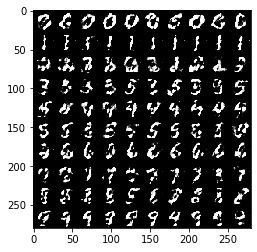

EPOCH 85 step 46450: D: loss = 0.6010956 G: loss=1.8152792 
EPOCH 85 step 46500: D: loss = 0.4971002 G: loss=1.8138702 
EPOCH 85 step 46550: D: loss = 0.6735404 G: loss=1.8552966 
EPOCH 85 step 46600: D: loss = 0.6967506 G: loss=1.6824315 
EPOCH 85 step 46650: D: loss = 0.6229622 G: loss=1.7800720 
EPOCH 85 step 46700: D: loss = 0.6830629 G: loss=1.7137916 
EPOCH 85 step 46750: D: loss = 0.5649800 G: loss=1.8779064 
EPOCH 85 step 46800: D: loss = 0.5455865 G: loss=1.8853583 
EPOCH 85 step 46850: D: loss = 0.6481243 G: loss=1.7168659 
EPOCH 85 step 46900: D: loss = 0.6470527 G: loss=1.8833590 
EPOCH 85 step 46950: D: loss = 0.5007390 G: loss=1.8515375 


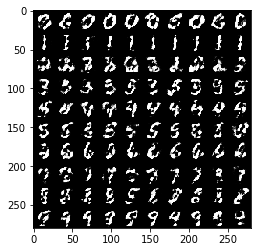

EPOCH 86 step 47000: D: loss = 0.6447064 G: loss=1.7812793 
EPOCH 86 step 47050: D: loss = 0.5442668 G: loss=1.8978938 
EPOCH 86 step 47100: D: loss = 0.5405972 G: loss=1.9669440 
EPOCH 86 step 47150: D: loss = 0.6255831 G: loss=1.7568381 
EPOCH 86 step 47200: D: loss = 0.6610627 G: loss=1.7607298 
EPOCH 86 step 47250: D: loss = 0.5139930 G: loss=1.8970103 
EPOCH 86 step 47300: D: loss = 0.5518335 G: loss=1.9290907 
EPOCH 86 step 47350: D: loss = 0.5994822 G: loss=1.7659011 
EPOCH 86 step 47400: D: loss = 0.5935589 G: loss=1.8723503 
EPOCH 86 step 47450: D: loss = 0.6653254 G: loss=1.8813527 
EPOCH 86 step 47500: D: loss = 0.6476749 G: loss=1.5900471 


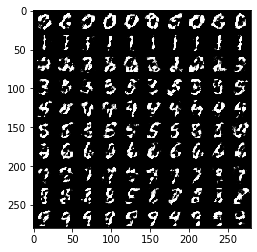

EPOCH 87 step 47550: D: loss = 0.5562490 G: loss=1.8915789 
EPOCH 87 step 47600: D: loss = 0.5211372 G: loss=1.8762448 
EPOCH 87 step 47650: D: loss = 0.5806108 G: loss=1.7428727 
EPOCH 87 step 47700: D: loss = 0.6027049 G: loss=1.8771446 
EPOCH 87 step 47750: D: loss = 0.6451248 G: loss=1.8182542 
EPOCH 87 step 47800: D: loss = 0.6942821 G: loss=1.4887146 
EPOCH 87 step 47850: D: loss = 0.5510883 G: loss=1.8832483 
EPOCH 87 step 47900: D: loss = 0.5794791 G: loss=1.9117227 
EPOCH 87 step 47950: D: loss = 0.5574123 G: loss=1.7420754 
EPOCH 87 step 48000: D: loss = 0.5186713 G: loss=1.8796899 


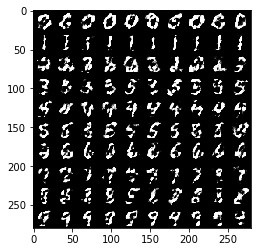

EPOCH 88 step 48050: D: loss = 0.5136530 G: loss=1.8959413 
EPOCH 88 step 48100: D: loss = 0.5889488 G: loss=1.8332160 
EPOCH 88 step 48150: D: loss = 0.5899564 G: loss=1.7902186 
EPOCH 88 step 48200: D: loss = 0.5606916 G: loss=1.8477216 
EPOCH 88 step 48250: D: loss = 0.6720074 G: loss=1.5838883 
EPOCH 88 step 48300: D: loss = 0.6187288 G: loss=1.7401356 
EPOCH 88 step 48350: D: loss = 0.6133631 G: loss=1.8337452 
EPOCH 88 step 48400: D: loss = 0.5756043 G: loss=1.8303506 
EPOCH 88 step 48450: D: loss = 0.6126800 G: loss=1.7786045 
EPOCH 88 step 48500: D: loss = 0.5313385 G: loss=1.8182380 
EPOCH 88 step 48550: D: loss = 0.5823448 G: loss=1.6643983 


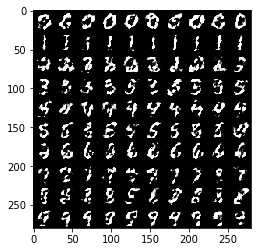

EPOCH 89 step 48600: D: loss = 0.5613323 G: loss=1.8450387 
EPOCH 89 step 48650: D: loss = 0.6203910 G: loss=1.7977934 
EPOCH 89 step 48700: D: loss = 0.5960870 G: loss=1.8199526 
EPOCH 89 step 48750: D: loss = 0.4832080 G: loss=1.8248386 
EPOCH 89 step 48800: D: loss = 0.5393535 G: loss=1.9474063 
EPOCH 89 step 48850: D: loss = 0.7370194 G: loss=1.6821086 
EPOCH 89 step 48900: D: loss = 0.5039421 G: loss=1.9848330 
EPOCH 89 step 48950: D: loss = 0.6037543 G: loss=1.9327946 
EPOCH 89 step 49000: D: loss = 0.5524141 G: loss=1.9663682 
EPOCH 89 step 49050: D: loss = 0.5781665 G: loss=1.8542511 
EPOCH 89 step 49100: D: loss = 0.6218379 G: loss=1.8675628 


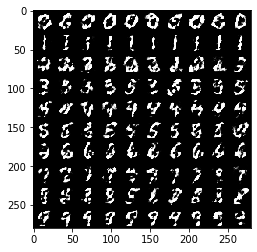

EPOCH 90 step 49150: D: loss = 0.5567337 G: loss=1.9665800 
EPOCH 90 step 49200: D: loss = 0.6126926 G: loss=1.8753003 
EPOCH 90 step 49250: D: loss = 0.5694991 G: loss=1.8930355 
EPOCH 90 step 49300: D: loss = 0.6158388 G: loss=1.9019265 
EPOCH 90 step 49350: D: loss = 0.6010815 G: loss=1.8118634 
EPOCH 90 step 49400: D: loss = 0.6123619 G: loss=1.8437872 
EPOCH 90 step 49450: D: loss = 0.4960802 G: loss=1.9344361 
EPOCH 90 step 49500: D: loss = 0.5147545 G: loss=2.0448685 
EPOCH 90 step 49550: D: loss = 0.5703762 G: loss=1.8773177 
EPOCH 90 step 49600: D: loss = 0.6579988 G: loss=1.7960293 
EPOCH 90 step 49650: D: loss = 0.5575815 G: loss=1.8444982 


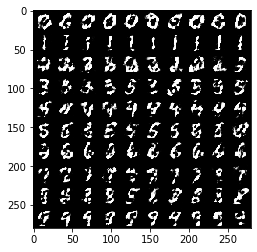

EPOCH 91 step 49700: D: loss = 0.5375457 G: loss=1.9326291 
EPOCH 91 step 49750: D: loss = 0.6364830 G: loss=1.8882260 
EPOCH 91 step 49800: D: loss = 0.5005104 G: loss=1.8679705 
EPOCH 91 step 49850: D: loss = 0.5388803 G: loss=1.9321461 
EPOCH 91 step 49900: D: loss = 0.6674615 G: loss=1.8297899 
EPOCH 91 step 49950: D: loss = 0.6081269 G: loss=1.8020885 
EPOCH 91 step 50000: D: loss = 0.5802075 G: loss=1.8795661 
EPOCH 91 step 50050: D: loss = 0.5639284 G: loss=1.6939118 
EPOCH 91 step 50100: D: loss = 0.5700631 G: loss=1.7769427 
EPOCH 91 step 50150: D: loss = 0.6019782 G: loss=1.8492063 
EPOCH 91 step 50200: D: loss = 0.5439814 G: loss=1.8347850 


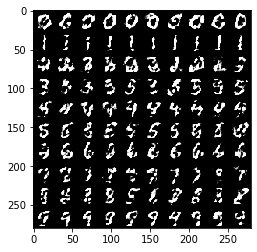

EPOCH 92 step 50250: D: loss = 0.6171936 G: loss=1.6822196 
EPOCH 92 step 50300: D: loss = 0.6079379 G: loss=1.7751397 
EPOCH 92 step 50350: D: loss = 0.5976940 G: loss=1.7987237 
EPOCH 92 step 50400: D: loss = 0.5374276 G: loss=1.8257264 
EPOCH 92 step 50450: D: loss = 0.6618881 G: loss=1.7078850 
EPOCH 92 step 50500: D: loss = 0.5590715 G: loss=1.8498442 
EPOCH 92 step 50550: D: loss = 0.4964619 G: loss=2.0065637 
EPOCH 92 step 50600: D: loss = 0.5889874 G: loss=1.7644900 
EPOCH 92 step 50650: D: loss = 0.5166008 G: loss=1.9516962 
EPOCH 92 step 50700: D: loss = 0.5677748 G: loss=1.8572994 
EPOCH 92 step 50750: D: loss = 0.5296845 G: loss=2.0749049 


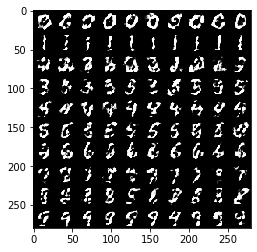

EPOCH 93 step 50800: D: loss = 0.6273696 G: loss=1.8125136 
EPOCH 93 step 50850: D: loss = 0.5659251 G: loss=1.9288719 
EPOCH 93 step 50900: D: loss = 0.5483561 G: loss=1.8814871 
EPOCH 93 step 50950: D: loss = 0.5939823 G: loss=1.8574985 
EPOCH 93 step 51000: D: loss = 0.5999387 G: loss=1.9652197 
EPOCH 93 step 51050: D: loss = 0.5581312 G: loss=1.8362861 
EPOCH 93 step 51100: D: loss = 0.6087739 G: loss=1.7813880 
EPOCH 93 step 51150: D: loss = 0.5515973 G: loss=1.9117999 
EPOCH 93 step 51200: D: loss = 0.6245077 G: loss=1.7161685 
EPOCH 93 step 51250: D: loss = 0.6612735 G: loss=1.8146726 
EPOCH 93 step 51300: D: loss = 0.6000659 G: loss=1.7784156 


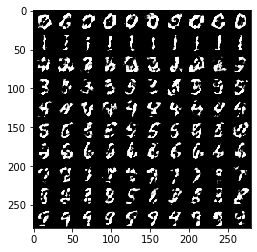

EPOCH 94 step 51350: D: loss = 0.6755143 G: loss=1.7743939 
EPOCH 94 step 51400: D: loss = 0.5575158 G: loss=1.9279431 
EPOCH 94 step 51450: D: loss = 0.5563635 G: loss=1.9234371 
EPOCH 94 step 51500: D: loss = 0.6030569 G: loss=1.9025266 
EPOCH 94 step 51550: D: loss = 0.5197225 G: loss=1.8398764 
EPOCH 94 step 51600: D: loss = 0.5590373 G: loss=1.8885220 
EPOCH 94 step 51650: D: loss = 0.5074832 G: loss=1.9764165 
EPOCH 94 step 51700: D: loss = 0.5542309 G: loss=2.0272205 
EPOCH 94 step 51750: D: loss = 0.5404388 G: loss=1.9999843 
EPOCH 94 step 51800: D: loss = 3.3668728 G: loss=0.6973518 
EPOCH 94 step 51850: D: loss = 3.3823986 G: loss=0.5176049 


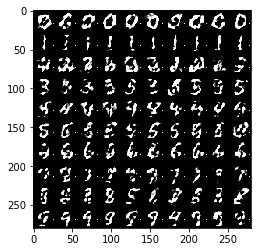

EPOCH 95 step 51900: D: loss = 3.1420770 G: loss=0.4376239 
EPOCH 95 step 51950: D: loss = 2.3927429 G: loss=0.5822276 
EPOCH 95 step 52000: D: loss = 2.2989192 G: loss=0.6137434 
EPOCH 95 step 52050: D: loss = 1.8878324 G: loss=0.6786132 
EPOCH 95 step 52100: D: loss = 1.7749059 G: loss=0.7504436 
EPOCH 95 step 52150: D: loss = 1.6917957 G: loss=0.7543393 
EPOCH 95 step 52200: D: loss = 1.4939646 G: loss=0.9598697 
EPOCH 95 step 52250: D: loss = 1.3539050 G: loss=1.0061582 
EPOCH 95 step 52300: D: loss = 1.3605814 G: loss=1.0802627 
EPOCH 95 step 52350: D: loss = 1.2221564 G: loss=1.0677207 
EPOCH 95 step 52400: D: loss = 1.1229377 G: loss=1.1373961 


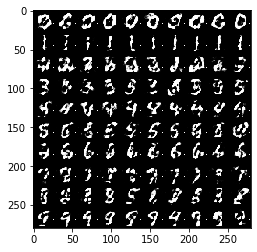

EPOCH 96 step 52450: D: loss = 0.9954628 G: loss=1.2921457 
EPOCH 96 step 52500: D: loss = 0.9876956 G: loss=1.3643786 
EPOCH 96 step 52550: D: loss = 1.0341456 G: loss=1.2190449 
EPOCH 96 step 52600: D: loss = 0.8658080 G: loss=1.4471263 
EPOCH 96 step 52650: D: loss = 0.8863386 G: loss=1.4277693 
EPOCH 96 step 52700: D: loss = 0.7371004 G: loss=1.5995765 
EPOCH 96 step 52750: D: loss = 0.7705815 G: loss=1.5678213 
EPOCH 96 step 52800: D: loss = 0.7942253 G: loss=1.4959676 
EPOCH 96 step 52850: D: loss = 0.6707579 G: loss=1.5686227 
EPOCH 96 step 52900: D: loss = 0.6204371 G: loss=1.7550480 
EPOCH 96 step 52950: D: loss = 0.6146252 G: loss=1.7763865 


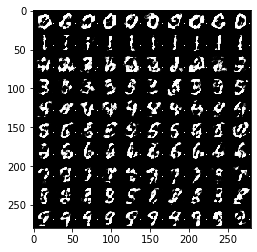

EPOCH 97 step 53000: D: loss = 0.6079847 G: loss=1.7556536 
EPOCH 97 step 53050: D: loss = 0.5971187 G: loss=1.6341231 
EPOCH 97 step 53100: D: loss = 0.4447266 G: loss=1.9006317 
EPOCH 97 step 53150: D: loss = 0.4175655 G: loss=2.0484891 
EPOCH 97 step 53200: D: loss = 0.4913825 G: loss=2.1005163 
EPOCH 97 step 53250: D: loss = 0.4210634 G: loss=2.2047372 
EPOCH 97 step 53300: D: loss = 0.4642628 G: loss=2.1373549 
EPOCH 97 step 53350: D: loss = 0.4848716 G: loss=2.1782408 
EPOCH 97 step 53400: D: loss = 0.4563794 G: loss=1.9415005 
EPOCH 97 step 53450: D: loss = 0.3391330 G: loss=2.2453423 
EPOCH 97 step 53500: D: loss = 0.3897967 G: loss=2.2904179 


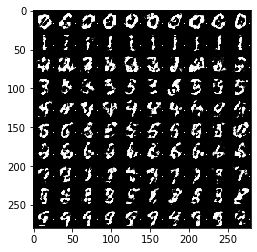

EPOCH 98 step 53550: D: loss = 0.3436602 G: loss=2.2565055 
EPOCH 98 step 53600: D: loss = 0.3961213 G: loss=2.2597308 
EPOCH 98 step 53650: D: loss = 0.3502446 G: loss=2.2413912 
EPOCH 98 step 53700: D: loss = 0.5876397 G: loss=1.7309226 
EPOCH 98 step 53750: D: loss = 0.6675776 G: loss=1.6703486 
EPOCH 98 step 53800: D: loss = 0.6962435 G: loss=1.4568672 
EPOCH 98 step 53850: D: loss = 0.6934562 G: loss=1.6466998 
EPOCH 98 step 53900: D: loss = 0.6688250 G: loss=1.5411179 
EPOCH 98 step 53950: D: loss = 0.6583340 G: loss=1.6319678 
EPOCH 98 step 54000: D: loss = 0.6532604 G: loss=1.5509818 
EPOCH 98 step 54050: D: loss = 0.6586998 G: loss=1.5928416 


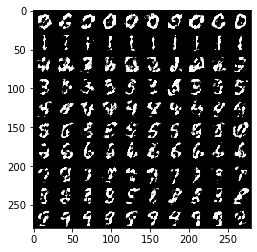

EPOCH 99 step 54100: D: loss = 0.6550393 G: loss=1.7463331 
EPOCH 99 step 54150: D: loss = 0.6857648 G: loss=1.6272339 
EPOCH 99 step 54200: D: loss = 0.6633795 G: loss=1.6064240 
EPOCH 99 step 54250: D: loss = 0.6799680 G: loss=1.6650188 
EPOCH 99 step 54300: D: loss = 0.6166757 G: loss=1.6431338 
EPOCH 99 step 54350: D: loss = 0.6199362 G: loss=1.6905546 
EPOCH 99 step 54400: D: loss = 0.5584155 G: loss=1.6976420 
EPOCH 99 step 54450: D: loss = 0.5720413 G: loss=1.7770061 
EPOCH 99 step 54500: D: loss = 0.5824454 G: loss=1.8243570 
EPOCH 99 step 54550: D: loss = 0.6556777 G: loss=1.7546122 
EPOCH 99 step 54600: D: loss = 0.6456171 G: loss=1.7264752 


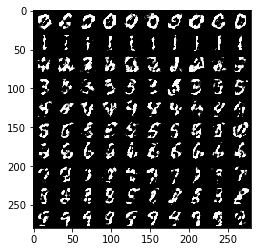

EPOCH 100 step 54650: D: loss = 0.6287785 G: loss=1.8140063 
EPOCH 100 step 54700: D: loss = 0.5609277 G: loss=1.8208251 
EPOCH 100 step 54750: D: loss = 0.6631421 G: loss=1.6228387 
EPOCH 100 step 54800: D: loss = 0.6460811 G: loss=1.7252966 
EPOCH 100 step 54850: D: loss = 0.5967842 G: loss=1.7612618 
EPOCH 100 step 54900: D: loss = 0.5731305 G: loss=1.7801433 
EPOCH 100 step 54950: D: loss = 0.5146325 G: loss=1.8195113 
EPOCH 100 step 55000: D: loss = 0.5701871 G: loss=1.7521439 
EPOCH 100 step 55050: D: loss = 0.4948430 G: loss=1.9081166 
EPOCH 100 step 55100: D: loss = 0.5792531 G: loss=1.7697349 


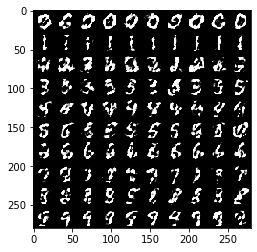

EPOCH 101 step 55150: D: loss = 0.5778617 G: loss=1.7971010 
EPOCH 101 step 55200: D: loss = 0.5741971 G: loss=1.7913640 
EPOCH 101 step 55250: D: loss = 0.6198847 G: loss=1.6240976 
EPOCH 101 step 55300: D: loss = 0.5876136 G: loss=1.7803965 
EPOCH 101 step 55350: D: loss = 0.5919459 G: loss=1.8753959 
EPOCH 101 step 55400: D: loss = 0.5100154 G: loss=1.8803616 
EPOCH 101 step 55450: D: loss = 0.5540003 G: loss=1.9041235 
EPOCH 101 step 55500: D: loss = 0.5887339 G: loss=1.8307409 
EPOCH 101 step 55550: D: loss = 0.5668402 G: loss=1.8251168 
EPOCH 101 step 55600: D: loss = 0.6293631 G: loss=1.7398057 
EPOCH 101 step 55650: D: loss = 0.6047585 G: loss=1.8672261 


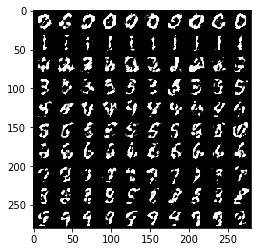

EPOCH 102 step 55700: D: loss = 0.6109498 G: loss=1.8133354 
EPOCH 102 step 55750: D: loss = 0.6419291 G: loss=1.6393354 
EPOCH 102 step 55800: D: loss = 0.5722424 G: loss=1.8517712 
EPOCH 102 step 55850: D: loss = 0.5267371 G: loss=1.8630141 
EPOCH 102 step 55900: D: loss = 0.5473557 G: loss=1.8884226 
EPOCH 102 step 55950: D: loss = 0.6340842 G: loss=1.7683659 
EPOCH 102 step 56000: D: loss = 0.6714320 G: loss=1.7252662 
EPOCH 102 step 56050: D: loss = 0.6380354 G: loss=1.6132814 
EPOCH 102 step 56100: D: loss = 0.5903497 G: loss=1.8572434 
EPOCH 102 step 56150: D: loss = 0.5915482 G: loss=1.7086124 
EPOCH 102 step 56200: D: loss = 0.6014262 G: loss=1.8860514 


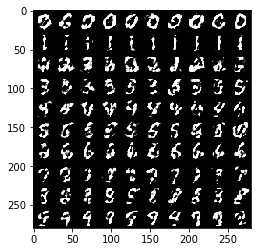

EPOCH 103 step 56250: D: loss = 0.5339134 G: loss=1.8536758 
EPOCH 103 step 56300: D: loss = 0.5982608 G: loss=1.7432915 
EPOCH 103 step 56350: D: loss = 0.5501482 G: loss=1.8223438 
EPOCH 103 step 56400: D: loss = 0.5621434 G: loss=1.8368847 
EPOCH 103 step 56450: D: loss = 0.5969007 G: loss=1.8706868 
EPOCH 103 step 56500: D: loss = 0.6417288 G: loss=1.8479199 
EPOCH 103 step 56550: D: loss = 0.5355915 G: loss=1.9414892 
EPOCH 103 step 56600: D: loss = 0.5668366 G: loss=1.9064474 
EPOCH 103 step 56650: D: loss = 0.6506781 G: loss=1.8043755 
EPOCH 103 step 56700: D: loss = 0.5335045 G: loss=1.8386581 
EPOCH 103 step 56750: D: loss = 0.6161404 G: loss=1.8622835 


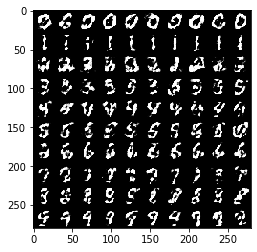

EPOCH 104 step 56800: D: loss = 0.5900800 G: loss=2.0269139 
EPOCH 104 step 56850: D: loss = 0.5596484 G: loss=1.9323573 
EPOCH 104 step 56900: D: loss = 0.6176891 G: loss=2.0024359 
EPOCH 104 step 56950: D: loss = 0.6068561 G: loss=1.8475251 
EPOCH 104 step 57000: D: loss = 0.5893860 G: loss=1.9490762 
EPOCH 104 step 57050: D: loss = 0.6077209 G: loss=1.7949115 
EPOCH 104 step 57100: D: loss = 0.5994005 G: loss=1.7788072 
EPOCH 104 step 57150: D: loss = 0.5438534 G: loss=1.9781562 
EPOCH 104 step 57200: D: loss = 0.5954412 G: loss=1.8707978 
EPOCH 104 step 57250: D: loss = 0.6281809 G: loss=1.8725455 
EPOCH 104 step 57300: D: loss = 0.6168243 G: loss=1.7882636 


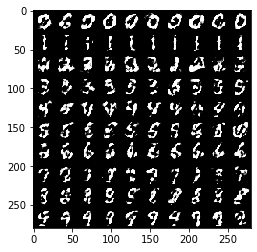

EPOCH 105 step 57350: D: loss = 0.6338632 G: loss=1.8758247 
EPOCH 105 step 57400: D: loss = 0.6230040 G: loss=1.8036156 
EPOCH 105 step 57450: D: loss = 0.5688396 G: loss=1.7941689 
EPOCH 105 step 57500: D: loss = 0.5228005 G: loss=1.9312716 
EPOCH 105 step 57550: D: loss = 0.5273986 G: loss=2.0158117 
EPOCH 105 step 57600: D: loss = 0.5985112 G: loss=1.9483614 
EPOCH 105 step 57650: D: loss = 0.6654385 G: loss=1.9609241 
EPOCH 105 step 57700: D: loss = 0.6572235 G: loss=1.8688275 
EPOCH 105 step 57750: D: loss = 0.5922003 G: loss=1.9266052 
EPOCH 105 step 57800: D: loss = 0.5508093 G: loss=1.9158700 
EPOCH 105 step 57850: D: loss = 0.6262758 G: loss=1.8580794 


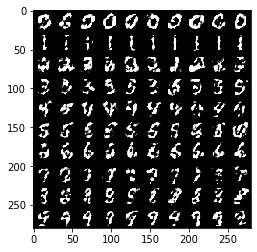

EPOCH 106 step 57900: D: loss = 0.5746777 G: loss=1.8773414 
EPOCH 106 step 57950: D: loss = 0.5116556 G: loss=2.0244725 
EPOCH 106 step 58000: D: loss = 0.6587499 G: loss=1.8204277 
EPOCH 106 step 58050: D: loss = 0.6001676 G: loss=1.9140085 
EPOCH 106 step 58100: D: loss = 0.5178596 G: loss=1.9371004 
EPOCH 106 step 58150: D: loss = 0.6159280 G: loss=1.8093623 
EPOCH 106 step 58200: D: loss = 0.5870860 G: loss=2.0333681 
EPOCH 106 step 58250: D: loss = 0.6652218 G: loss=1.8001913 
EPOCH 106 step 58300: D: loss = 0.5848764 G: loss=1.7840376 
EPOCH 106 step 58350: D: loss = 0.4814753 G: loss=2.0183694 
EPOCH 106 step 58400: D: loss = 0.5910796 G: loss=1.8322582 


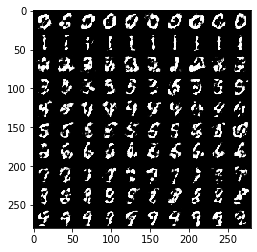

EPOCH 107 step 58450: D: loss = 0.6436789 G: loss=1.7790730 
EPOCH 107 step 58500: D: loss = 0.6596560 G: loss=1.6667242 
EPOCH 107 step 58550: D: loss = 0.6887782 G: loss=1.7556159 
EPOCH 107 step 58600: D: loss = 0.5256204 G: loss=1.9492418 
EPOCH 107 step 58650: D: loss = 0.6020650 G: loss=1.8261403 
EPOCH 107 step 58700: D: loss = 0.6760563 G: loss=1.7460289 
EPOCH 107 step 58750: D: loss = 0.5664593 G: loss=1.8509899 
EPOCH 107 step 58800: D: loss = 0.5896009 G: loss=1.8385407 
EPOCH 107 step 58850: D: loss = 0.6501460 G: loss=1.7168801 
EPOCH 107 step 58900: D: loss = 0.6280460 G: loss=1.8510156 
EPOCH 107 step 58950: D: loss = 0.5391091 G: loss=2.0671074 


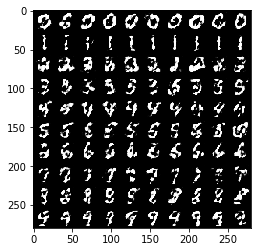

EPOCH 108 step 59000: D: loss = 0.5623280 G: loss=1.9185565 
EPOCH 108 step 59050: D: loss = 0.5884828 G: loss=2.0240192 
EPOCH 108 step 59100: D: loss = 0.4746890 G: loss=2.0713043 
EPOCH 108 step 59150: D: loss = 0.6421758 G: loss=1.8875831 
EPOCH 108 step 59200: D: loss = 0.5738379 G: loss=1.9600968 
EPOCH 108 step 59250: D: loss = 0.5581736 G: loss=1.9809139 
EPOCH 108 step 59300: D: loss = 0.6832438 G: loss=1.8546188 
EPOCH 108 step 59350: D: loss = 0.4795008 G: loss=1.9517953 
EPOCH 108 step 59400: D: loss = 0.6288224 G: loss=1.8583341 
EPOCH 108 step 59450: D: loss = 0.5782588 G: loss=2.0401549 
EPOCH 108 step 59500: D: loss = 0.6203052 G: loss=1.8674228 


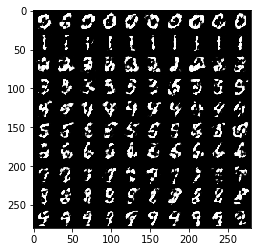

EPOCH 109 step 59550: D: loss = 0.5840470 G: loss=1.9311965 
EPOCH 109 step 59600: D: loss = 0.5635285 G: loss=1.8078151 
EPOCH 109 step 59650: D: loss = 0.6362674 G: loss=1.8157253 
EPOCH 109 step 59700: D: loss = 0.6095157 G: loss=1.9702371 
EPOCH 109 step 59750: D: loss = 0.5018284 G: loss=1.9268863 
EPOCH 109 step 59800: D: loss = 0.5466398 G: loss=1.9216859 
EPOCH 109 step 59850: D: loss = 0.5730684 G: loss=1.8323206 
EPOCH 109 step 59900: D: loss = 0.5815738 G: loss=1.9438527 
EPOCH 109 step 59950: D: loss = 0.6570320 G: loss=1.8457955 
EPOCH 109 step 60000: D: loss = 0.5977063 G: loss=1.9514673 
EPOCH 109 step 60050: D: loss = 0.5901459 G: loss=1.7583072 


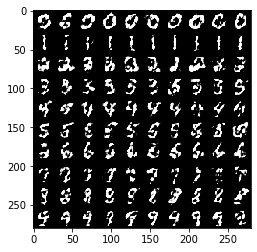

EPOCH 110 step 60100: D: loss = 0.5662773 G: loss=2.0241954 
EPOCH 110 step 60150: D: loss = 0.5513765 G: loss=1.9696770 
EPOCH 110 step 60200: D: loss = 0.5382658 G: loss=1.9763794 
EPOCH 110 step 60250: D: loss = 0.5544990 G: loss=1.7821140 
EPOCH 110 step 60300: D: loss = 0.5740623 G: loss=1.9730215 
EPOCH 110 step 60350: D: loss = 0.5104907 G: loss=1.9991274 
EPOCH 110 step 60400: D: loss = 0.6353024 G: loss=1.9432845 
EPOCH 110 step 60450: D: loss = 0.6444762 G: loss=1.7750182 
EPOCH 110 step 60500: D: loss = 0.4882829 G: loss=2.0405867 
EPOCH 110 step 60550: D: loss = 0.5480260 G: loss=1.9551991 
EPOCH 110 step 60600: D: loss = 0.5401416 G: loss=1.8569739 


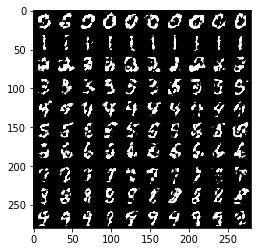

EPOCH 111 step 60650: D: loss = 0.5342174 G: loss=1.9888679 
EPOCH 111 step 60700: D: loss = 0.5596831 G: loss=1.9687700 
EPOCH 111 step 60750: D: loss = 0.5925249 G: loss=1.9723330 
EPOCH 111 step 60800: D: loss = 0.5750775 G: loss=1.9792559 
EPOCH 111 step 60850: D: loss = 0.5435705 G: loss=2.0812721 
EPOCH 111 step 60900: D: loss = 0.5691668 G: loss=2.0019245 
EPOCH 111 step 60950: D: loss = 0.5906840 G: loss=1.8325543 
EPOCH 111 step 61000: D: loss = 0.4555231 G: loss=2.1040659 
EPOCH 111 step 61050: D: loss = 0.6213030 G: loss=1.8526623 
EPOCH 111 step 61100: D: loss = 0.5431345 G: loss=2.0437624 
EPOCH 111 step 61150: D: loss = 0.5469064 G: loss=1.8913379 


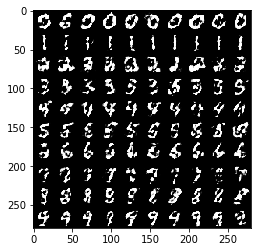

EPOCH 112 step 61200: D: loss = 0.5566727 G: loss=1.8746798 
EPOCH 112 step 61250: D: loss = 0.5982057 G: loss=1.8861103 
EPOCH 112 step 61300: D: loss = 0.5697318 G: loss=1.9050752 
EPOCH 112 step 61350: D: loss = 0.5485582 G: loss=1.8506380 
EPOCH 112 step 61400: D: loss = 0.5401698 G: loss=2.0159698 
EPOCH 112 step 61450: D: loss = 0.6645457 G: loss=1.7513666 
EPOCH 112 step 61500: D: loss = 0.5714102 G: loss=1.9116836 
EPOCH 112 step 61550: D: loss = 0.4604088 G: loss=2.1790609 
EPOCH 112 step 61600: D: loss = 0.4935762 G: loss=1.9873105 
EPOCH 112 step 61650: D: loss = 0.5098052 G: loss=1.9343777 


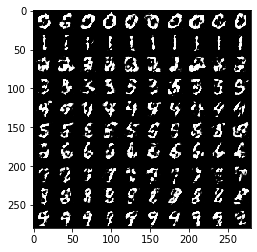

EPOCH 113 step 61700: D: loss = 0.4924226 G: loss=1.9398069 
EPOCH 113 step 61750: D: loss = 0.6666399 G: loss=1.8271683 
EPOCH 113 step 61800: D: loss = 0.5268567 G: loss=2.1557155 
EPOCH 113 step 61850: D: loss = 0.5894502 G: loss=1.9781920 
EPOCH 113 step 61900: D: loss = 0.4975109 G: loss=1.9689949 
EPOCH 113 step 61950: D: loss = 6.2142591 G: loss=0.4211439 
EPOCH 113 step 62000: D: loss = 6.8147860 G: loss=0.2784366 
EPOCH 113 step 62050: D: loss = 5.3081923 G: loss=0.2851969 
EPOCH 113 step 62100: D: loss = 4.4814954 G: loss=0.2659820 
EPOCH 113 step 62150: D: loss = 3.8059301 G: loss=0.3043246 
EPOCH 113 step 62200: D: loss = 3.7056375 G: loss=0.2725719 


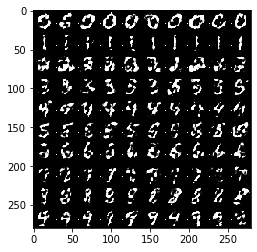

EPOCH 114 step 62250: D: loss = 3.2739701 G: loss=0.3878506 
EPOCH 114 step 62300: D: loss = 3.0386796 G: loss=0.3851483 
EPOCH 114 step 62350: D: loss = 2.8531570 G: loss=0.4245988 
EPOCH 114 step 62400: D: loss = 2.2708473 G: loss=0.6099050 
EPOCH 114 step 62450: D: loss = 2.6132917 G: loss=0.5040855 
EPOCH 114 step 62500: D: loss = 2.3470521 G: loss=0.6341355 
EPOCH 114 step 62550: D: loss = 2.3045957 G: loss=0.6398683 
EPOCH 114 step 62600: D: loss = 2.2252798 G: loss=0.7126877 
EPOCH 114 step 62650: D: loss = 1.8796229 G: loss=0.7734432 
EPOCH 114 step 62700: D: loss = 1.8972182 G: loss=0.8364317 
EPOCH 114 step 62750: D: loss = 1.8720731 G: loss=0.8041387 


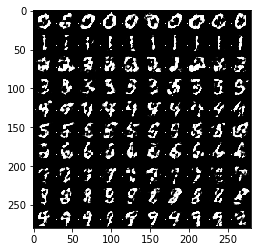

EPOCH 115 step 62800: D: loss = 1.7279782 G: loss=0.9449456 
EPOCH 115 step 62850: D: loss = 1.6386571 G: loss=0.9532778 
EPOCH 115 step 62900: D: loss = 1.6713123 G: loss=1.0177734 
EPOCH 115 step 62950: D: loss = 1.3974408 G: loss=0.9933550 
EPOCH 115 step 63000: D: loss = 1.3987021 G: loss=0.9988183 
EPOCH 115 step 63050: D: loss = 1.2798886 G: loss=1.0594065 
EPOCH 115 step 63100: D: loss = 1.3050030 G: loss=1.0263282 
EPOCH 115 step 63150: D: loss = 1.2435635 G: loss=1.0676088 
EPOCH 115 step 63200: D: loss = 1.2521769 G: loss=1.0607791 
EPOCH 115 step 63250: D: loss = 1.2056967 G: loss=1.2034926 
EPOCH 115 step 63300: D: loss = 1.2135670 G: loss=1.1287503 


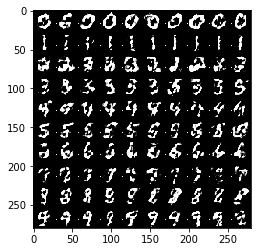

EPOCH 116 step 63350: D: loss = 1.0448081 G: loss=1.2464654 
EPOCH 116 step 63400: D: loss = 1.0230520 G: loss=1.1856894 
EPOCH 116 step 63450: D: loss = 1.0838063 G: loss=1.2387154 
EPOCH 116 step 63500: D: loss = 0.8999141 G: loss=1.3934453 
EPOCH 116 step 63550: D: loss = 0.8270721 G: loss=1.4071361 
EPOCH 116 step 63600: D: loss = 1.0681502 G: loss=1.2573838 
EPOCH 116 step 63650: D: loss = 0.7709618 G: loss=1.4972897 
EPOCH 116 step 63700: D: loss = 0.6762145 G: loss=1.5711086 
EPOCH 116 step 63750: D: loss = 0.9759797 G: loss=1.3411756 
EPOCH 116 step 63800: D: loss = 0.7814640 G: loss=1.5347730 
EPOCH 116 step 63850: D: loss = 0.6760688 G: loss=1.6841352 


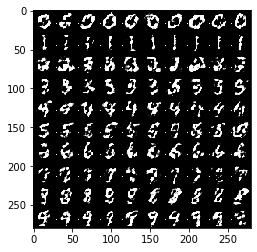

EPOCH 117 step 63900: D: loss = 0.7989942 G: loss=1.4989992 
EPOCH 117 step 63950: D: loss = 0.7118286 G: loss=1.5691371 
EPOCH 117 step 64000: D: loss = 0.6113272 G: loss=1.8060799 
EPOCH 117 step 64050: D: loss = 0.5327801 G: loss=1.7877104 
EPOCH 117 step 64100: D: loss = 0.5864326 G: loss=1.7528862 
EPOCH 117 step 64150: D: loss = 0.6249238 G: loss=1.7360551 
EPOCH 117 step 64200: D: loss = 0.5608863 G: loss=1.7488937 
EPOCH 117 step 64250: D: loss = 0.4861212 G: loss=1.8535247 
EPOCH 117 step 64300: D: loss = 0.4889633 G: loss=2.0044348 
EPOCH 117 step 64350: D: loss = 0.4946881 G: loss=1.9456849 
EPOCH 117 step 64400: D: loss = 0.4662189 G: loss=1.9182475 


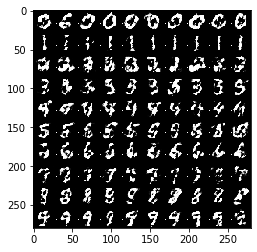

EPOCH 118 step 64450: D: loss = 0.4673422 G: loss=1.8931577 
EPOCH 118 step 64500: D: loss = 0.4080811 G: loss=2.0166392 
EPOCH 118 step 64550: D: loss = 0.3883284 G: loss=2.1712904 
EPOCH 118 step 64600: D: loss = 0.3970563 G: loss=2.0792379 
EPOCH 118 step 64650: D: loss = 0.4330823 G: loss=2.0651975 
EPOCH 118 step 64700: D: loss = 0.3597935 G: loss=2.1877818 
EPOCH 118 step 64750: D: loss = 0.3250671 G: loss=2.0817623 
EPOCH 118 step 64800: D: loss = 0.3837102 G: loss=2.0291958 
EPOCH 118 step 64850: D: loss = 0.3630604 G: loss=2.0734868 
EPOCH 118 step 64900: D: loss = 0.3153421 G: loss=2.1874471 
EPOCH 118 step 64950: D: loss = 0.3118671 G: loss=2.2729168 


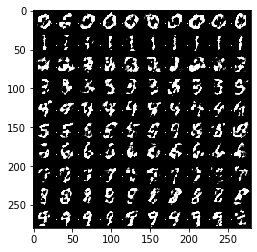

EPOCH 119 step 65000: D: loss = 0.2871208 G: loss=2.2675743 
EPOCH 119 step 65050: D: loss = 0.6342174 G: loss=1.5449615 
EPOCH 119 step 65100: D: loss = 0.7063397 G: loss=1.4938363 
EPOCH 119 step 65150: D: loss = 0.6669370 G: loss=1.5944592 
EPOCH 119 step 65200: D: loss = 0.6497833 G: loss=1.4782958 
EPOCH 119 step 65250: D: loss = 0.7697783 G: loss=1.5855678 
EPOCH 119 step 65300: D: loss = 0.5984516 G: loss=1.6581490 
EPOCH 119 step 65350: D: loss = 0.7307518 G: loss=1.5705872 
EPOCH 119 step 65400: D: loss = 0.6529925 G: loss=1.5876994 
EPOCH 119 step 65450: D: loss = 0.5808532 G: loss=1.7664064 
EPOCH 119 step 65500: D: loss = 0.6113077 G: loss=1.6275014 


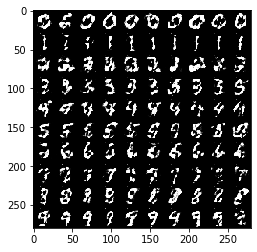

EPOCH 120 step 65550: D: loss = 0.7002202 G: loss=1.4596944 
EPOCH 120 step 65600: D: loss = 0.5845265 G: loss=1.7744862 
EPOCH 120 step 65650: D: loss = 0.6010770 G: loss=1.7757168 
EPOCH 120 step 65700: D: loss = 0.5759988 G: loss=1.7870920 
EPOCH 120 step 65750: D: loss = 0.6257136 G: loss=1.6546786 
EPOCH 120 step 65800: D: loss = 0.6130511 G: loss=1.7348485 
EPOCH 120 step 65850: D: loss = 0.5691009 G: loss=1.6807070 
EPOCH 120 step 65900: D: loss = 0.5298423 G: loss=1.8049338 
EPOCH 120 step 65950: D: loss = 0.5534374 G: loss=1.8783908 
EPOCH 120 step 66000: D: loss = 0.6058048 G: loss=1.7381731 
EPOCH 120 step 66050: D: loss = 0.6528022 G: loss=1.5425591 


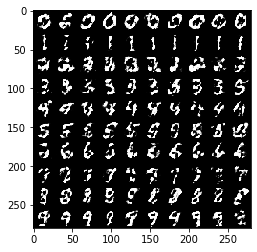

EPOCH 121 step 66100: D: loss = 0.5160538 G: loss=1.9346366 
EPOCH 121 step 66150: D: loss = 0.5774419 G: loss=1.8465934 
EPOCH 121 step 66200: D: loss = 0.6294720 G: loss=1.7769489 
EPOCH 121 step 66250: D: loss = 0.5019362 G: loss=1.9498937 
EPOCH 121 step 66300: D: loss = 0.5445675 G: loss=1.7933065 
EPOCH 121 step 66350: D: loss = 0.4912981 G: loss=2.0136313 
EPOCH 121 step 66400: D: loss = 0.6682925 G: loss=1.5744586 
EPOCH 121 step 66450: D: loss = 0.5782996 G: loss=1.8528478 
EPOCH 121 step 66500: D: loss = 0.6678970 G: loss=1.6342108 
EPOCH 121 step 66550: D: loss = 0.5478944 G: loss=1.7833519 
EPOCH 121 step 66600: D: loss = 0.5523007 G: loss=1.8935057 


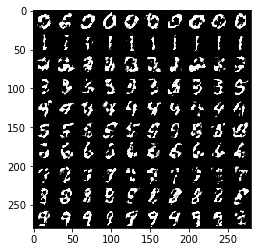

EPOCH 122 step 66650: D: loss = 0.6487354 G: loss=1.8170480 
EPOCH 122 step 66700: D: loss = 0.5465792 G: loss=1.9473784 
EPOCH 122 step 66750: D: loss = 0.5835291 G: loss=1.9044558 
EPOCH 122 step 66800: D: loss = 0.5988115 G: loss=1.7455506 
EPOCH 122 step 66850: D: loss = 0.5431668 G: loss=1.9211822 
EPOCH 122 step 66900: D: loss = 0.5744553 G: loss=1.8683550 
EPOCH 122 step 66950: D: loss = 0.6272820 G: loss=1.8972656 
EPOCH 122 step 67000: D: loss = 0.5342737 G: loss=2.0682945 
EPOCH 122 step 67050: D: loss = 0.6104427 G: loss=1.8668464 
EPOCH 122 step 67100: D: loss = 0.5905225 G: loss=1.8260325 
EPOCH 122 step 67150: D: loss = 0.5993800 G: loss=1.9677629 


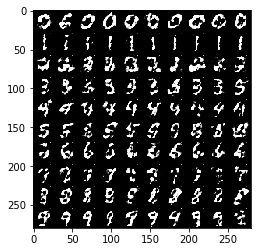

EPOCH 123 step 67200: D: loss = 0.5137991 G: loss=1.9383311 
EPOCH 123 step 67250: D: loss = 0.6392111 G: loss=1.8612831 
EPOCH 123 step 67300: D: loss = 0.5463477 G: loss=1.9793944 
EPOCH 123 step 67350: D: loss = 0.5841843 G: loss=1.9162488 
EPOCH 123 step 67400: D: loss = 0.5483809 G: loss=1.9015647 
EPOCH 123 step 67450: D: loss = 0.5350543 G: loss=1.9087662 
EPOCH 123 step 67500: D: loss = 0.6048381 G: loss=2.0520875 
EPOCH 123 step 67550: D: loss = 0.6336776 G: loss=1.7234037 
EPOCH 123 step 67600: D: loss = 0.5780320 G: loss=1.8791652 
EPOCH 123 step 67650: D: loss = 0.5817313 G: loss=1.7880089 
EPOCH 123 step 67700: D: loss = 0.5984156 G: loss=1.7882150 


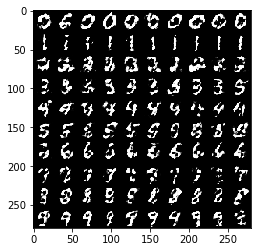

EPOCH 124 step 67750: D: loss = 0.5931053 G: loss=1.8526797 
EPOCH 124 step 67800: D: loss = 0.5650319 G: loss=1.9882500 
EPOCH 124 step 67850: D: loss = 0.5784425 G: loss=2.0525706 
EPOCH 124 step 67900: D: loss = 0.6101959 G: loss=1.9627571 
EPOCH 124 step 67950: D: loss = 0.5901150 G: loss=1.8554080 
EPOCH 124 step 68000: D: loss = 0.5949230 G: loss=1.7591078 
EPOCH 124 step 68050: D: loss = 0.5970745 G: loss=1.7904278 
EPOCH 124 step 68100: D: loss = 0.5427909 G: loss=1.9287477 
EPOCH 124 step 68150: D: loss = 0.5825777 G: loss=1.9216263 
EPOCH 124 step 68200: D: loss = 0.5631763 G: loss=1.8812870 
EPOCH 124 step 68250: D: loss = 0.6429101 G: loss=1.8673460 


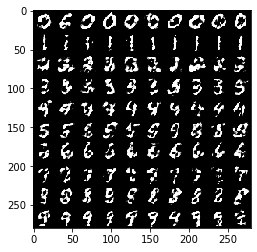

EPOCH 125 step 68300: D: loss = 0.6005033 G: loss=2.0196750 
EPOCH 125 step 68350: D: loss = 0.5198265 G: loss=2.0448709 
EPOCH 125 step 68400: D: loss = 0.6685307 G: loss=1.7400736 
EPOCH 125 step 68450: D: loss = 0.6019422 G: loss=1.7693689 
EPOCH 125 step 68500: D: loss = 0.5966861 G: loss=1.8748188 
EPOCH 125 step 68550: D: loss = 0.5507474 G: loss=1.9440303 
EPOCH 125 step 68600: D: loss = 0.5349795 G: loss=1.9035143 
EPOCH 125 step 68650: D: loss = 0.5199978 G: loss=1.8838696 
EPOCH 125 step 68700: D: loss = 0.6122431 G: loss=1.8714057 
EPOCH 125 step 68750: D: loss = 0.5708360 G: loss=1.8890347 


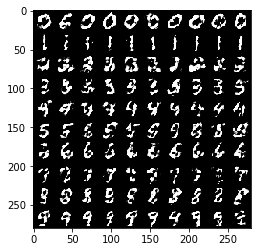

EPOCH 126 step 68800: D: loss = 0.5838332 G: loss=1.8747120 
EPOCH 126 step 68850: D: loss = 0.6350224 G: loss=1.8117406 
EPOCH 126 step 68900: D: loss = 0.6006802 G: loss=1.7687145 
EPOCH 126 step 68950: D: loss = 0.5570989 G: loss=1.9202975 
EPOCH 126 step 69000: D: loss = 0.6275856 G: loss=1.8662304 
EPOCH 126 step 69050: D: loss = 0.5042278 G: loss=2.0490246 
EPOCH 126 step 69100: D: loss = 0.5646014 G: loss=1.8625473 
EPOCH 126 step 69150: D: loss = 0.6981709 G: loss=1.7533059 
EPOCH 126 step 69200: D: loss = 0.5712771 G: loss=1.8836235 
EPOCH 126 step 69250: D: loss = 0.5974057 G: loss=1.8814805 
EPOCH 126 step 69300: D: loss = 0.6704090 G: loss=2.0481892 


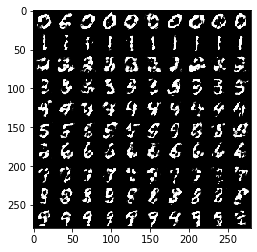

EPOCH 127 step 69350: D: loss = 0.5186217 G: loss=2.0076613 
EPOCH 127 step 69400: D: loss = 0.6275817 G: loss=1.8050375 
EPOCH 127 step 69450: D: loss = 0.6085465 G: loss=1.7708931 
EPOCH 127 step 69500: D: loss = 0.5082906 G: loss=1.8934081 
EPOCH 127 step 69550: D: loss = 0.5787520 G: loss=1.8597789 
EPOCH 127 step 69600: D: loss = 0.6029149 G: loss=1.9925525 
EPOCH 127 step 69650: D: loss = 0.6774536 G: loss=1.7200495 
EPOCH 127 step 69700: D: loss = 0.6392392 G: loss=1.7701274 
EPOCH 127 step 69750: D: loss = 0.5862399 G: loss=1.8046038 
EPOCH 127 step 69800: D: loss = 0.5857003 G: loss=1.8027375 
EPOCH 127 step 69850: D: loss = 0.5341258 G: loss=1.9308408 


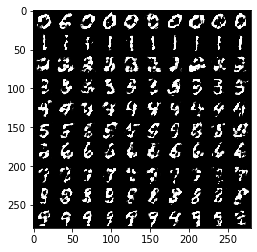

EPOCH 128 step 69900: D: loss = 0.6303215 G: loss=1.7173741 
EPOCH 128 step 69950: D: loss = 0.5755038 G: loss=1.7864511 
EPOCH 128 step 70000: D: loss = 0.5463901 G: loss=1.8671684 
EPOCH 128 step 70050: D: loss = 0.5622957 G: loss=1.9632646 
EPOCH 128 step 70100: D: loss = 0.6255858 G: loss=1.8536339 
EPOCH 128 step 70150: D: loss = 0.5293343 G: loss=2.0555158 
EPOCH 128 step 70200: D: loss = 0.6003413 G: loss=1.9595633 
EPOCH 128 step 70250: D: loss = 0.5662879 G: loss=2.0936005 
EPOCH 128 step 70300: D: loss = 0.6567522 G: loss=1.8545747 
EPOCH 128 step 70350: D: loss = 0.5728761 G: loss=1.8477008 
EPOCH 128 step 70400: D: loss = 0.4795340 G: loss=1.9261361 


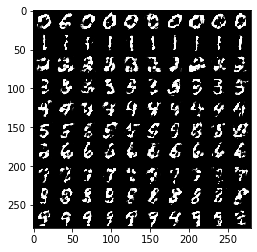

EPOCH 129 step 70450: D: loss = 0.5547874 G: loss=2.1757870 
EPOCH 129 step 70500: D: loss = 0.5786121 G: loss=1.9858991 
EPOCH 129 step 70550: D: loss = 0.5488101 G: loss=2.1160073 
EPOCH 129 step 70600: D: loss = 0.5255716 G: loss=1.9892220 
EPOCH 129 step 70650: D: loss = 0.5553744 G: loss=1.9246545 
EPOCH 129 step 70700: D: loss = 0.6158130 G: loss=1.7797492 
EPOCH 129 step 70750: D: loss = 0.6830035 G: loss=1.8996452 
EPOCH 129 step 70800: D: loss = 0.5867393 G: loss=1.9569451 
EPOCH 129 step 70850: D: loss = 0.6847416 G: loss=1.7583494 
EPOCH 129 step 70900: D: loss = 0.6168330 G: loss=1.9096599 
EPOCH 129 step 70950: D: loss = 0.6029267 G: loss=1.9596254 


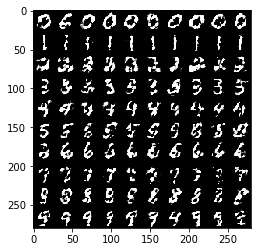

EPOCH 130 step 71000: D: loss = 0.5984172 G: loss=1.8832610 
EPOCH 130 step 71050: D: loss = 0.6788733 G: loss=1.8417439 
EPOCH 130 step 71100: D: loss = 0.5828487 G: loss=1.8739381 
EPOCH 130 step 71150: D: loss = 0.4829431 G: loss=2.1268868 
EPOCH 130 step 71200: D: loss = 0.5634238 G: loss=1.9845834 
EPOCH 130 step 71250: D: loss = 0.5733125 G: loss=1.9763026 
EPOCH 130 step 71300: D: loss = 0.5475079 G: loss=2.1553526 
EPOCH 130 step 71350: D: loss = 0.6217527 G: loss=1.9592636 
EPOCH 130 step 71400: D: loss = 0.5780455 G: loss=1.8347270 
EPOCH 130 step 71450: D: loss = 0.5470783 G: loss=2.0283546 
EPOCH 130 step 71500: D: loss = 0.5687915 G: loss=2.0956481 


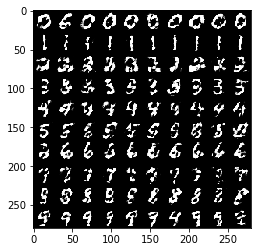

EPOCH 131 step 71550: D: loss = 0.5548859 G: loss=1.9204205 
EPOCH 131 step 71600: D: loss = 0.5801958 G: loss=1.8447425 
EPOCH 131 step 71650: D: loss = 0.7203754 G: loss=1.7968735 
EPOCH 131 step 71700: D: loss = 0.5347415 G: loss=2.0258975 
EPOCH 131 step 71750: D: loss = 0.5205988 G: loss=2.0483921 
EPOCH 131 step 71800: D: loss = 0.5448440 G: loss=2.0565090 
EPOCH 131 step 71850: D: loss = 0.5020419 G: loss=2.1059196 
EPOCH 131 step 71900: D: loss = 0.5578437 G: loss=1.9704030 
EPOCH 131 step 71950: D: loss = 0.5812061 G: loss=1.9491115 
EPOCH 131 step 72000: D: loss = 0.5287712 G: loss=1.9883826 
EPOCH 131 step 72050: D: loss = 0.5469911 G: loss=2.0362978 


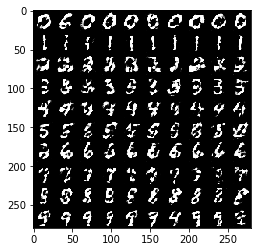

EPOCH 132 step 72100: D: loss = 0.6582482 G: loss=1.7476606 
EPOCH 132 step 72150: D: loss = 0.6721232 G: loss=1.8062288 
EPOCH 132 step 72200: D: loss = 0.6041060 G: loss=2.0659361 
EPOCH 132 step 72250: D: loss = 0.4762651 G: loss=2.0175266 
EPOCH 132 step 72300: D: loss = 0.5959138 G: loss=1.9788082 
EPOCH 132 step 72350: D: loss = 0.6326799 G: loss=1.7872789 
EPOCH 132 step 72400: D: loss = 0.6533876 G: loss=1.8299723 
EPOCH 132 step 72450: D: loss = 0.5197347 G: loss=2.0360661 
EPOCH 132 step 72500: D: loss = 0.5817554 G: loss=1.8455948 
EPOCH 132 step 72550: D: loss = 0.5579925 G: loss=1.9288644 
EPOCH 132 step 72600: D: loss = 0.6201947 G: loss=1.9551413 


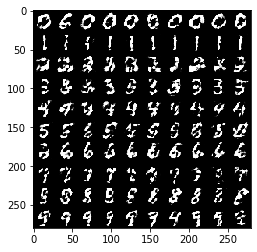

EPOCH 133 step 72650: D: loss = 0.5603152 G: loss=2.1415803 
EPOCH 133 step 72700: D: loss = 0.6145535 G: loss=1.9933996 
EPOCH 133 step 72750: D: loss = 0.4650460 G: loss=2.1487706 
EPOCH 133 step 72800: D: loss = 0.6682285 G: loss=1.9715776 
EPOCH 133 step 72850: D: loss = 0.5939535 G: loss=2.0099504 
EPOCH 133 step 72900: D: loss = 0.5802674 G: loss=2.2141349 
EPOCH 133 step 72950: D: loss = 0.6038504 G: loss=1.9883840 
EPOCH 133 step 73000: D: loss = 0.5234387 G: loss=1.9192650 
EPOCH 133 step 73050: D: loss = 0.6516542 G: loss=1.8958342 
EPOCH 133 step 73100: D: loss = 0.5096143 G: loss=1.9332719 
EPOCH 133 step 73150: D: loss = 0.5708876 G: loss=1.9638550 


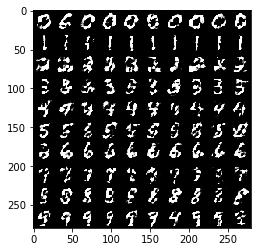

EPOCH 134 step 73200: D: loss = 0.5762734 G: loss=1.8777418 
EPOCH 134 step 73250: D: loss = 0.5234572 G: loss=1.9661648 
EPOCH 134 step 73300: D: loss = 0.6241575 G: loss=1.7306801 
EPOCH 134 step 73350: D: loss = 0.5180523 G: loss=2.0833623 
EPOCH 134 step 73400: D: loss = 0.5901092 G: loss=1.9285414 
EPOCH 134 step 73450: D: loss = 0.4965754 G: loss=2.0020669 
EPOCH 134 step 73500: D: loss = 0.5539440 G: loss=2.1202281 
EPOCH 134 step 73550: D: loss = 0.5172926 G: loss=2.0423813 
EPOCH 134 step 73600: D: loss = 0.6895778 G: loss=1.8972442 
EPOCH 134 step 73650: D: loss = 0.5724415 G: loss=1.9993083 
EPOCH 134 step 73700: D: loss = 0.5887210 G: loss=1.8863959 


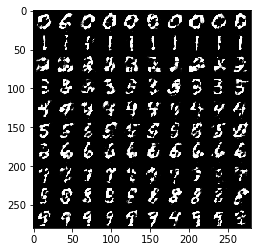

EPOCH 135 step 73750: D: loss = 0.5771934 G: loss=2.0284262 
EPOCH 135 step 73800: D: loss = 0.5930071 G: loss=1.9536686 
EPOCH 135 step 73850: D: loss = 0.5485799 G: loss=2.0066087 
EPOCH 135 step 73900: D: loss = 0.5549627 G: loss=2.0653276 
EPOCH 135 step 73950: D: loss = 0.5349655 G: loss=2.0674219 
EPOCH 135 step 74000: D: loss = 0.5152344 G: loss=2.0049400 
EPOCH 135 step 74050: D: loss = 0.5828702 G: loss=1.9720159 
EPOCH 135 step 74100: D: loss = 0.6352640 G: loss=1.9738572 
EPOCH 135 step 74150: D: loss = 0.5786908 G: loss=2.0708528 
EPOCH 135 step 74200: D: loss = 0.6858335 G: loss=1.8706285 
EPOCH 135 step 74250: D: loss = 0.5203984 G: loss=1.9683905 


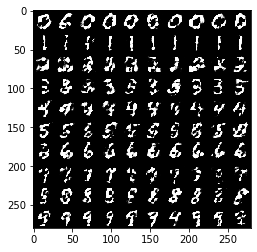

EPOCH 136 step 74300: D: loss = 0.5672191 G: loss=1.9623685 
EPOCH 136 step 74350: D: loss = 0.4974158 G: loss=1.9894490 
EPOCH 136 step 74400: D: loss = 0.5760404 G: loss=2.0174274 
EPOCH 136 step 74450: D: loss = 0.6609480 G: loss=1.8231683 
EPOCH 136 step 74500: D: loss = 0.5367682 G: loss=2.1950984 
EPOCH 136 step 74550: D: loss = 0.5856841 G: loss=2.0052111 
EPOCH 136 step 74600: D: loss = 0.5485848 G: loss=1.9064853 
EPOCH 136 step 74650: D: loss = 0.5046064 G: loss=1.9728553 
EPOCH 136 step 74700: D: loss = 0.6212938 G: loss=1.9537945 
EPOCH 136 step 74750: D: loss = 0.5422265 G: loss=2.0139618 
EPOCH 136 step 74800: D: loss = 0.6290689 G: loss=1.8215562 


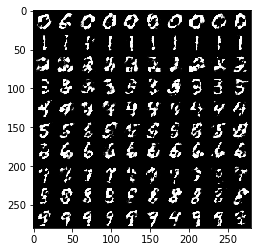

EPOCH 137 step 74850: D: loss = 0.5257228 G: loss=1.9988778 
EPOCH 137 step 74900: D: loss = 0.5881903 G: loss=1.9993775 
EPOCH 137 step 74950: D: loss = 0.5869778 G: loss=1.8504236 
EPOCH 137 step 75000: D: loss = 0.6085753 G: loss=2.0539706 
EPOCH 137 step 75050: D: loss = 0.5726445 G: loss=1.9272970 
EPOCH 137 step 75100: D: loss = 0.6388355 G: loss=1.8273718 
EPOCH 137 step 75150: D: loss = 0.5663963 G: loss=2.0467503 
EPOCH 137 step 75200: D: loss = 0.5327165 G: loss=2.1521521 
EPOCH 137 step 75250: D: loss = 0.5304701 G: loss=2.1619279 
EPOCH 137 step 75300: D: loss = 0.5046426 G: loss=2.0436668 


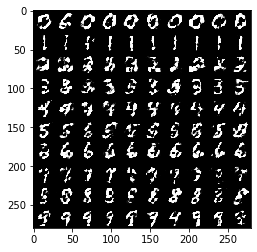

EPOCH 138 step 75350: D: loss = 0.5777729 G: loss=1.9878365 
EPOCH 138 step 75400: D: loss = 0.6572320 G: loss=1.9300014 
EPOCH 138 step 75450: D: loss = 0.5028182 G: loss=2.1775055 
EPOCH 138 step 75500: D: loss = 0.5710965 G: loss=1.9915296 
EPOCH 138 step 75550: D: loss = 0.5843850 G: loss=1.9842473 
EPOCH 138 step 75600: D: loss = 0.6602769 G: loss=2.0151026 
EPOCH 138 step 75650: D: loss = 0.7354589 G: loss=1.8663812 
EPOCH 138 step 75700: D: loss = 0.5794851 G: loss=1.8963991 
EPOCH 138 step 75750: D: loss = 0.5759717 G: loss=1.8003767 
EPOCH 138 step 75800: D: loss = 0.5133398 G: loss=2.1256068 
EPOCH 138 step 75850: D: loss = 0.5538747 G: loss=1.8521421 


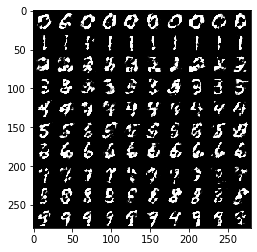

EPOCH 139 step 75900: D: loss = 0.4731266 G: loss=2.0220344 
EPOCH 139 step 75950: D: loss = 0.6944561 G: loss=1.9008105 
EPOCH 139 step 76000: D: loss = 0.5344157 G: loss=2.1067276 
EPOCH 139 step 76050: D: loss = 0.4578764 G: loss=2.0974813 
EPOCH 139 step 76100: D: loss = 0.5521300 G: loss=1.9935005 
EPOCH 139 step 76150: D: loss = 0.7241390 G: loss=1.7533139 
EPOCH 139 step 76200: D: loss = 0.5926845 G: loss=2.1986241 
EPOCH 139 step 76250: D: loss = 0.6393533 G: loss=1.9843193 
EPOCH 139 step 76300: D: loss = 0.4636064 G: loss=2.0577309 
EPOCH 139 step 76350: D: loss = 0.5466983 G: loss=2.0647495 
EPOCH 139 step 76400: D: loss = 0.5532914 G: loss=1.9442449 


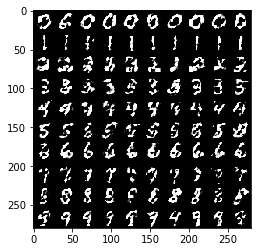

EPOCH 140 step 76450: D: loss = 0.5158657 G: loss=2.1217098 
EPOCH 140 step 76500: D: loss = 0.5734104 G: loss=2.0737674 
EPOCH 140 step 76550: D: loss = 0.6316828 G: loss=1.9286220 
EPOCH 140 step 76600: D: loss = 0.5508792 G: loss=1.9921224 
EPOCH 140 step 76650: D: loss = 0.6176278 G: loss=2.0131748 
EPOCH 140 step 76700: D: loss = 0.5698576 G: loss=1.9651756 
EPOCH 140 step 76750: D: loss = 0.6050420 G: loss=1.9524808 
EPOCH 140 step 76800: D: loss = 0.5754626 G: loss=2.0270629 
EPOCH 140 step 76850: D: loss = 0.4706631 G: loss=2.0666108 
EPOCH 140 step 76900: D: loss = 0.6089854 G: loss=1.9304297 
EPOCH 140 step 76950: D: loss = 0.5489693 G: loss=1.8985591 


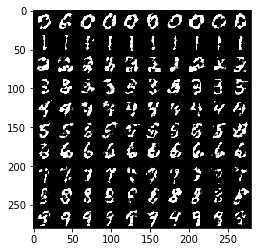

EPOCH 141 step 77000: D: loss = 0.5517668 G: loss=2.0760264 
EPOCH 141 step 77050: D: loss = 0.7168188 G: loss=1.7789029 
EPOCH 141 step 77100: D: loss = 0.5669562 G: loss=2.0422990 
EPOCH 141 step 77150: D: loss = 0.6216444 G: loss=1.9552398 
EPOCH 141 step 77200: D: loss = 0.6390033 G: loss=1.7999322 
EPOCH 141 step 77250: D: loss = 0.6046479 G: loss=1.9174626 
EPOCH 141 step 77300: D: loss = 0.5673252 G: loss=2.0166416 
EPOCH 141 step 77350: D: loss = 0.6133573 G: loss=1.7758725 
EPOCH 141 step 77400: D: loss = 0.6237342 G: loss=1.7915202 
EPOCH 141 step 77450: D: loss = 0.6243881 G: loss=2.0781951 
EPOCH 141 step 77500: D: loss = 0.5408360 G: loss=2.0002520 


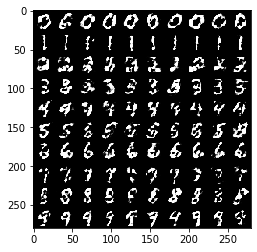

EPOCH 142 step 77550: D: loss = 0.6739868 G: loss=1.8618698 
EPOCH 142 step 77600: D: loss = 0.5918823 G: loss=1.9887253 
EPOCH 142 step 77650: D: loss = 0.4772292 G: loss=2.1051521 
EPOCH 142 step 77700: D: loss = 0.6304390 G: loss=2.0146484 
EPOCH 142 step 77750: D: loss = 0.6931368 G: loss=1.9222664 
EPOCH 142 step 77800: D: loss = 0.6795607 G: loss=2.0360975 
EPOCH 142 step 77850: D: loss = 0.4940517 G: loss=2.0006642 
EPOCH 142 step 77900: D: loss = 0.6019191 G: loss=1.8884753 
EPOCH 142 step 77950: D: loss = 0.5805763 G: loss=2.1040382 
EPOCH 142 step 78000: D: loss = 0.5573875 G: loss=2.1618502 
EPOCH 142 step 78050: D: loss = 0.6454646 G: loss=1.9415712 


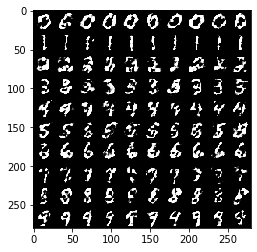

EPOCH 143 step 78100: D: loss = 0.6145594 G: loss=1.9639548 
EPOCH 143 step 78150: D: loss = 0.6328724 G: loss=1.9349325 
EPOCH 143 step 78200: D: loss = 0.4863043 G: loss=2.2806506 
EPOCH 143 step 78250: D: loss = 0.5637958 G: loss=2.0994892 
EPOCH 143 step 78300: D: loss = 0.6142175 G: loss=1.9028780 
EPOCH 143 step 78350: D: loss = 0.4893420 G: loss=2.0355201 
EPOCH 143 step 78400: D: loss = 0.5435558 G: loss=1.9759424 
EPOCH 143 step 78450: D: loss = 0.6515984 G: loss=1.9797819 
EPOCH 143 step 78500: D: loss = 0.6082186 G: loss=1.9859296 
EPOCH 143 step 78550: D: loss = 0.6402620 G: loss=1.7858564 
EPOCH 143 step 78600: D: loss = 0.6612868 G: loss=1.8118283 


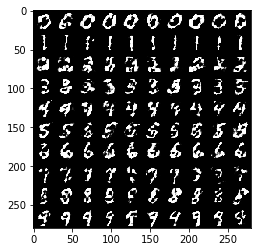

EPOCH 144 step 78650: D: loss = 0.6056001 G: loss=2.0106778 
EPOCH 144 step 78700: D: loss = 0.5892665 G: loss=2.1313701 
EPOCH 144 step 78750: D: loss = 0.5949146 G: loss=2.0717919 
EPOCH 144 step 78800: D: loss = 0.6217231 G: loss=2.0182173 
EPOCH 144 step 78850: D: loss = 0.6035820 G: loss=1.8477497 
EPOCH 144 step 78900: D: loss = 0.6734694 G: loss=1.9751201 
EPOCH 144 step 78950: D: loss = 0.5852368 G: loss=2.0615039 
EPOCH 144 step 79000: D: loss = 0.6654198 G: loss=1.9328314 
EPOCH 144 step 79050: D: loss = 0.4379293 G: loss=2.2475843 
EPOCH 144 step 79100: D: loss = 0.5682879 G: loss=2.2192123 
EPOCH 144 step 79150: D: loss = 0.5100989 G: loss=1.9817052 


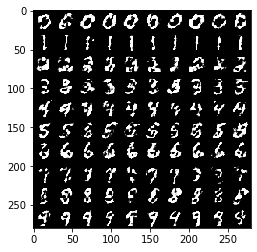

EPOCH 145 step 79200: D: loss = 0.6024547 G: loss=1.9605647 
EPOCH 145 step 79250: D: loss = 0.5211515 G: loss=1.9967932 
EPOCH 145 step 79300: D: loss = 0.5985344 G: loss=2.1516771 
EPOCH 145 step 79350: D: loss = 0.5271399 G: loss=2.0024047 
EPOCH 145 step 79400: D: loss = 0.5794061 G: loss=1.9803944 
EPOCH 145 step 79450: D: loss = 0.6042153 G: loss=1.8882611 
EPOCH 145 step 79500: D: loss = 0.6214927 G: loss=2.0056553 
EPOCH 145 step 79550: D: loss = 0.4783297 G: loss=2.1473351 
EPOCH 145 step 79600: D: loss = 0.5810065 G: loss=2.0055616 
EPOCH 145 step 79650: D: loss = 0.5994099 G: loss=1.8662505 
EPOCH 145 step 79700: D: loss = 0.5743074 G: loss=1.8892113 


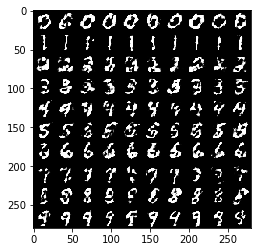

EPOCH 146 step 79750: D: loss = 0.6232237 G: loss=2.0193911 
EPOCH 146 step 79800: D: loss = 0.6580570 G: loss=1.9111742 
EPOCH 146 step 79850: D: loss = 0.6363327 G: loss=1.8642355 
EPOCH 146 step 79900: D: loss = 0.5512722 G: loss=2.1180949 
EPOCH 146 step 79950: D: loss = 0.6343251 G: loss=1.8931061 
EPOCH 146 step 80000: D: loss = 0.5391692 G: loss=2.0510430 
EPOCH 146 step 80050: D: loss = 0.4893327 G: loss=2.1935859 
EPOCH 146 step 80100: D: loss = 0.6861551 G: loss=1.7872472 
EPOCH 146 step 80150: D: loss = 0.5888390 G: loss=1.8522266 
EPOCH 146 step 80200: D: loss = 0.6730212 G: loss=1.9437841 
EPOCH 146 step 80250: D: loss = 0.5248575 G: loss=1.9940356 


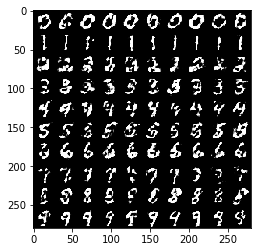

EPOCH 147 step 80300: D: loss = 0.6072757 G: loss=2.0377023 
EPOCH 147 step 80350: D: loss = 0.6239550 G: loss=1.9934788 
EPOCH 147 step 80400: D: loss = 0.6131185 G: loss=1.9750469 
EPOCH 147 step 80450: D: loss = 0.6258394 G: loss=1.9568859 
EPOCH 147 step 80500: D: loss = 0.5182074 G: loss=2.1176784 
EPOCH 147 step 80550: D: loss = 0.5841184 G: loss=1.8902287 
EPOCH 147 step 80600: D: loss = 0.6108454 G: loss=1.8543979 
EPOCH 147 step 80650: D: loss = 2.6952322 G: loss=1.4404998 
EPOCH 147 step 80700: D: loss = 10.1882515 G: loss=0.4360350 
EPOCH 147 step 80750: D: loss = 10.8381748 G: loss=0.3392394 
EPOCH 147 step 80800: D: loss = 11.2303591 G: loss=0.1777128 


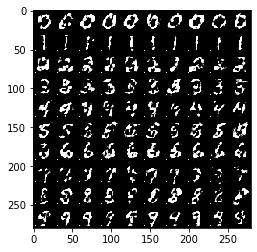

EPOCH 148 step 80850: D: loss = 9.8461361 G: loss=0.0998684 
EPOCH 148 step 80900: D: loss = 9.7576323 G: loss=0.0873303 
EPOCH 148 step 80950: D: loss = 8.7980137 G: loss=0.0567872 
EPOCH 148 step 81000: D: loss = 8.1983948 G: loss=0.0886301 
EPOCH 148 step 81050: D: loss = 7.4306507 G: loss=0.0815037 
EPOCH 148 step 81100: D: loss = 7.1999707 G: loss=0.0912784 
EPOCH 148 step 81150: D: loss = 6.7608924 G: loss=0.0936164 
EPOCH 148 step 81200: D: loss = 6.7308550 G: loss=0.1098266 
EPOCH 148 step 81250: D: loss = 6.9191399 G: loss=0.1075764 
EPOCH 148 step 81300: D: loss = 5.9986229 G: loss=0.1218505 
EPOCH 148 step 81350: D: loss = 5.7006063 G: loss=0.1987121 


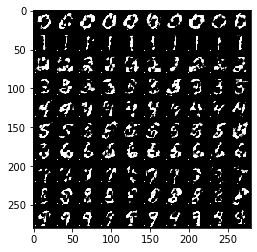

EPOCH 149 step 81400: D: loss = 5.5220242 G: loss=0.1943621 
EPOCH 149 step 81450: D: loss = 5.6611881 G: loss=0.1891860 
EPOCH 149 step 81500: D: loss = 4.9934716 G: loss=0.2585065 
EPOCH 149 step 81550: D: loss = 5.2704105 G: loss=0.2168699 
EPOCH 149 step 81600: D: loss = 4.7132263 G: loss=0.2775404 
EPOCH 149 step 81650: D: loss = 4.4474392 G: loss=0.3450899 
EPOCH 149 step 81700: D: loss = 4.5259390 G: loss=0.3034562 
EPOCH 149 step 81750: D: loss = 4.1759338 G: loss=0.3370605 
EPOCH 149 step 81800: D: loss = 4.5378780 G: loss=0.2807507 
EPOCH 149 step 81850: D: loss = 4.6851058 G: loss=0.3423066 
EPOCH 149 step 81900: D: loss = 3.9528499 G: loss=0.4278926 


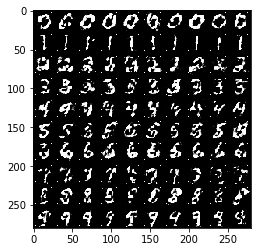

EPOCH 150 step 81950: D: loss = 3.3844733 G: loss=0.5182467 
EPOCH 150 step 82000: D: loss = 3.1591301 G: loss=0.6072631 
EPOCH 150 step 82050: D: loss = 3.8209391 G: loss=0.4713629 
EPOCH 150 step 82100: D: loss = 3.5259414 G: loss=0.6372588 
EPOCH 150 step 82150: D: loss = 3.4771922 G: loss=0.5565460 
EPOCH 150 step 82200: D: loss = 3.2497234 G: loss=0.5598394 
EPOCH 150 step 82250: D: loss = 3.0286429 G: loss=0.5564343 
EPOCH 150 step 82300: D: loss = 2.7849698 G: loss=0.6023039 
EPOCH 150 step 82350: D: loss = 2.8720999 G: loss=0.6102241 


In [ ]:
sample_z = np.random.uniform(-1 , 1 , size = [batch_size , sample_size])

y = tf.placeholder(tf.float32, [None , y_dim])

images = tf.placeholder(tf.float32, [batch_size, output_size, output_size, channel])

z = tf.placeholder(tf.float32, [None , sample_size])

fake_images = gern_net(batch_size, z , y ,sample_size, y_dim,output_size)

##the loss of gerenate network
D_pro , D_logits = dis_net(images, y ,  False)

G_pro, G_logits = dis_net(fake_images , y , True)

#### TODO ####
# DEFINE LOSS FUNCTION #
D_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_logits, labels=tf.ones([batch_size, 1])))
D_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=G_logits, labels=tf.zeros([batch_size, 1])))
D_loss = D_loss_real + D_loss_fake
G_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=G_logits, labels=tf.ones([batch_size, 1])))

#############

t_vars = tf.trainable_variables()

d_var = [var for var in t_vars if 'dis' in var.name]
g_var = [var for var in t_vars if 'gen' in var.name]

opti_D = tf.train.AdamOptimizer(learning_rate=learning_rate , beta1=0.5).minimize(D_loss , var_list=d_var)
opti_G = tf.train.AdamOptimizer(learning_rate=learning_rate , beta1=0.5).minimize(G_loss , var_list=g_var)

init = tf.global_variables_initializer()
config = tf.ConfigProto()
config.gpu_options.allow_growth = True

with tf.Session(config=config) as sess:

    sess.run(init)
    e = 0
    step = 0

    while e <= EPOCH:
        batch_num = 0
        while batch_num < len(data_array) / batch_size - 1:

            step = step + 1

            realbatch_array , real_labels = getNext_batch(data_array , data_y , batch_num, batch_size)
            
            #Get the z
            batch_z = np.random.uniform(-1 , 1 , size=[batch_size , sample_size])

            _ = sess.run(opti_D, feed_dict={images:realbatch_array, z:batch_z , y:real_labels})
            _ = sess.run(opti_G, feed_dict={z: batch_z , y:real_labels})

            batch_num += 1

            if step % loss_step == 0:

                d_get_loss = sess.run(D_loss , feed_dict = {images:realbatch_array , z:batch_z , y:real_labels})
                g_get_loss = sess.run(G_loss , feed_dict = {z: batch_z , y:real_labels})
                print("EPOCH %d step %d: D: loss = %.7f G: loss=%.7f " % (e , step , d_get_loss , g_get_loss))

            if np.mod(step , display_step) == 1:

                sample_images = sess.run(fake_images , feed_dict={z:sample_z , y:sample_label(batch_size)})
                sample_images = sample_images[:100,:,:,:]
                image_name = './{}/train_{:02d}_{:04d}.png'.format(sample_dir , e , step)
                save_images(sample_images , [10,10] , image_name)

        img = mpimg.imread(image_name)
        imgplot = plt.imshow(img)
        plt.show()

        e = e + 1
        batch_num = 0
